In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from scipy.integrate import quad

import seaborn as sns
from scipy import stats
from scipy.stats import truncnorm
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

import torch
import torch.nn as nn
import torch.optim as optim
#import torchvision
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
#import torchinfo

import warnings
import os
from copy import deepcopy

import plotting
import dataset_fctns
import modelling_fctns
from ML_fctns import *

from datetime import datetime
from dateutil.relativedelta import relativedelta
#from suntimes import SunTimes  

In [2]:
def train_test_ds_by_year(x_train, y_train, test_years = [2015, 2016, 2017], year_column = -2, train_proportion = 0.8):
    samples_in_test_years = torch.isin(x_train[:, year_column, 0], torch.Tensor(test_years))
    train_ds = TensorDataset(x_train[~samples_in_test_years, :, :], y_train[~samples_in_test_years, :])
    val_ds = TensorDataset(x_train[samples_in_test_years, :, :], y_train[samples_in_test_years, :])
    return train_ds, val_ds

def train_test_dl_by_year(x_train, y_train, bs = 500, n_channels=1, train_proportion = 0.8, test_years = [2015, 2016, 2017], year_column = -2):
    train_ds, val_ds = train_test_ds_by_year(x_train, y_train, train_proportion = train_proportion, test_years = test_years, year_column = year_column)
    train_dl = DataLoader(train_ds, batch_size=bs)
    val_dl = DataLoader(val_ds, batch_size=bs)
    train_dl = WrappedDataLoader(train_dl, lambda x, y: preprocess(x, y, channels =n_channels))
    val_dl = WrappedDataLoader(val_dl, lambda x, y: preprocess(x, y, channels =n_channels))
    return train_dl, val_dl

In [3]:
def Wang_Engel_Integral(T, T_min, T_opt, T_max):
    alpha = np.log(2)/np.log( (T_max - T_min)/(T_opt - T_min) )
    f_1 = (2*(np.sign(T - T_min)*(T - T_min))**(alpha + 1))*((T_opt - T_min)**alpha) / (alpha + 1)
    f_2 = ((np.sign(T - T_min)*(T - T_min))**((2*alpha) + 1)) / ((2*alpha) + 1)
    f_T = ( f_1 - f_2 ) / ((T_opt - T_min)**(2*alpha))
    f_T = np.nan_to_num(f_T)

    f_1_max = (2*(T_max - T_min)**(alpha + 1))*((T_opt - T_min)**alpha) / (alpha + 1)
    f_2_max = ((T_max - T_min)**((2*alpha) + 1)) / ((2*alpha) + 1)
    f_T_max = ( f_1_max - f_2_max ) / ((T_opt - T_min)**(2*alpha))
    return f_T*(T >= T_min)*(T<= T_max) + f_T_max*(T > T_max)
    
def Convolved_Wang_Engel(T, T_min, T_opt, T_max, gap = 4):
    return (1/(2*gap))*(Wang_Engel_Integral(np.minimum(T + gap, T_max), T_min, T_opt, T_max) - Wang_Engel_Integral(np.maximum(T - gap, T_min), T_min, T_opt, T_max))#
    
def integrand(T, T_min, T_opt, T_max, d, s, gap):
    #return modelling_fctns.Wang_Engel_Temp_response(T, T_min, T_opt, T_max, beta = 1.5)*np.exp(-((T - d)**2)/(2*(s**2)))
    return Convolved_Wang_Engel(T, T_min, T_opt, T_max, gap = gap)*(1/np.sqrt(2*np.pi*(s**2)))*np.exp(-((T - d)**2)/(2*(s**2)))
    
def expint(T_min, T_opt, T_max, d, s, gap):
    return quad(integrand, T_min, T_max, args=(T_min, T_opt, T_max, d, s, gap))[0]
vec_expint = np.vectorize(expint)

In [4]:
def make_error_df(R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, model, region, eval_method):
    error_df = pd.DataFrame({
        'model': [model],
        'region': [region],
        'evaluation method': [eval_method],
        'R2': [np.mean(R2s)],
        'Bias (obs minus modelled)': [np.mean(Biases)],
        'Variance': [np.mean(Variances)],
        'RMSE': [np.mean(RMSEs)],
        'STD': [np.mean(STDs)],
        'Corr': [np.mean(Corrs)],
        'Min': [np.mean(Mins)],
        'LQ': [np.mean(LQs)],
        'Median': [np.mean(Medians)],
        'UQ': [np.mean(UQs)],
        'Max': [np.mean(Maxs)]
    })
    return error_df

In [5]:
def K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, model_args, savename_prefix = 'KFold', freeze_params = False, loss = 'NLL', CNN=False, bce=False, lr = 0.01, MMD=False, n_channels = 4, DTF = False, obs_method = False, custom_loss = None):
    ## LSTM_args: input_dim, hidden_dim, num_layers, output_dim
    # Initialize the k-fold cross validation
    kf = KFold(n_splits=k_folds, shuffle=True, random_state = 1)
    # Loop through each fold
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss_values = []
    R2s = []
    Biases = []
    Variances = []

    RMSEs = []
    STDs = []
    Corrs = []

    Mins = []
    LQs = []
    Medians = []
    UQs = []
    Maxs = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(train_ds)):
        print(f"Fold {fold + 1}")

        # Define the data loaders for the current fold
        train_dl = DataLoader(
            dataset=train_ds,
            batch_size=bs,
            sampler=torch.utils.data.SubsetRandomSampler(train_idx),
        )
        val_dl = DataLoader(
            dataset=train_ds,
            batch_size=bs,
            sampler=torch.utils.data.SubsetRandomSampler(test_idx),
        )

        # Initialize the model and optimizer
        model = model_class(*model_args).to(device)
        
        optimizer = optim.Adam(model.parameters(), lr=lr)

        if loss == 'NLL':
            criterion = nn.NLLLoss()
        elif loss == 'BCE':
            criterion = nn.BCELoss()
        elif loss == 'MSE':
            criterion = custom_loss
        # Train the model on the current fold
        if freeze_params:
            for param in [model.u0, model.u1, model.u2, model.u3, model.p0]:
                param.requires_grad = False

        model_loss = fit_for_kf(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = savename_prefix + str(fold + 1), CNN=CNN, bce=bce)
        loss_values.append(model_loss)

        #Now look at stats for model:
        model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
        model_path = os.path.join(model_dir, savename_prefix + str(fold + 1) + ".pt")
        checkpoint = torch.load(model_path, weights_only=True)
        TS_model = model_class(*model_args).to(device)
        TS_model.load_state_dict(checkpoint['model_state_dict'])

        comparison_frame = get_comparison_frame(savename_prefix + str(fold + 1), TS_model, val_dl, bce=bce, CNN=CNN, MMD=MMD, n_channels = n_channels, DTF = DTF, obs_method = obs_method)
        comparison_frame['Error'] = comparison_frame['observed'] - comparison_frame['fitted']

        bias_model = comparison_frame['Error'].mean()
        RMSE = np.sqrt(np.mean((comparison_frame['Error'] - bias_model)**2))
        STD = comparison_frame['fitted'].std() 
        Corr = comparison_frame['observed'].corr(comparison_frame['fitted'])

        RMSEs.append(RMSE)
        STDs.append(STD)
        Corrs.append(Corr)
        
        Mins.append(comparison_frame['Error'].min())
        LQs.append(comparison_frame['Error'].quantile(0.25))
        Medians.append(comparison_frame['Error'].median())
        UQs.append(comparison_frame['Error'].quantile(0.75))
        Maxs.append(comparison_frame['Error'].max())

        rsquared = r2_score(comparison_frame['observed'], comparison_frame['fitted'])
        bias = comparison_frame['observed'].mean() - comparison_frame['fitted'].mean()
        variance_modelled = comparison_frame[f'fitted'].var()
        
        R2s.append(rsquared)
        Biases.append(bias)
        Variances.append(variance_modelled)

    return loss_values, R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs

In [6]:
def get_comparison_frame(savename, TS_model, dl, bce=False, CNN=False, MMD=False, n_channels = 4, DTF = False, obs_method = False):
    model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
    model_path = os.path.join(model_dir, savename + ".pt")
    checkpoint = torch.load(model_path, weights_only=True)
    TS_model.load_state_dict(checkpoint['model_state_dict'])
    list_logs = []
    list_observed = []
    list_stations = []
    list_years = []
    for xb, yb in dl:
        with torch.no_grad():
            if CNN:
                if MMD:
                    list_logs.append(TS_model(xb)[0])
                else:
                    list_logs.append(TS_model(xb))
            else:
                list_logs.append(TS_model(xb.transpose(1, 2)))
            list_years.append(xb[:, n_channels, 0])
            list_stations.append(xb[:, n_channels + 1, 0])
            #print(TS_model(xb.transpose(1, 2)))
        list_observed.append(yb)
    logs = torch.squeeze(torch.cat(list_logs))
    stations = torch.squeeze(torch.cat(list_stations))
    years = torch.squeeze(torch.cat(list_years))
    observed = torch.cat(list_observed)
    print(logs.shape, torch.cat(list_logs, dim=0).shape)
    if not(DTF):
        if bce:
            fitted = torch.round(logs)
        else:
            fitted = torch.argmax(logs, dim=2)
    if DTF:
        logs = torch.round(logs)
        observed_days = mindex_at_0(observed)
        observed_days = observed[:, 0]
        observed_days = 90 + 100 - observed[:, 90]
        if obs_method:
            fitted_days = observed_days + logs[range(0, logs.shape[0]), observed_days.int()]
        else:
            fitted_days = mindex_at_0(logs)
            fitted_days = 90 + 100 - logs[:, 90]
            #fitted_days = logs[:, 90]
        print(torch.sum(fitted_days < 30), ' fits too small')
    else:
        L = fitted.shape[1]
        fitted_days = L - fitted.sum(dim=1)
        observed_days = L - observed.sum(dim=1)
    #print(stations.numpy().squeeze())
    comparison_frame = pd.DataFrame({'Stations_id': stations.numpy().squeeze(), 'year': years.numpy().squeeze(), 'fitted': fitted_days.numpy().squeeze(), 'observed': observed_days.numpy().squeeze()})
    return comparison_frame
    

In [7]:
def get_comparison_frame(savename, TS_model, dl, bce=False, CNN=False):
    model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
    model_path = os.path.join(model_dir, savename + ".pt")
    checkpoint = torch.load(model_path, weights_only=True)
    TS_model.load_state_dict(checkpoint['model_state_dict'])
    list_logs = []
    list_observed = []
    list_stations = []
    list_years = []
    for xb, yb in dl:
        with torch.no_grad():
            if CNN:
                list_logs.append(TS_model(xb))
            else:
                list_logs.append(TS_model(xb.transpose(1, 2)))
            list_years.append(xb[:, 4, 0])
            list_stations.append(xb[:, 5, 0])
            #print(TS_model(xb.transpose(1, 2)))
        list_observed.append(yb)
    logs = torch.squeeze(torch.cat(list_logs))
    stations = torch.squeeze(torch.cat(list_stations))
    years = torch.squeeze(torch.cat(list_years))
    if bce:
        fitted = torch.round(logs)
    else:
        fitted = torch.argmax(logs, dim=2)
    L = fitted.shape[1]
    fitted_days = L - fitted.sum(dim=1)
    observed = torch.cat(list_observed)
    observed_days = L - observed.sum(dim=1)
    #print(stations.numpy().squeeze())
    comparison_frame = pd.DataFrame({'Stations_id': stations.numpy().squeeze(), 'year': years.numpy().squeeze(), 'fitted': fitted_days.numpy().squeeze(), 'observed': observed_days.numpy().squeeze()})
    return comparison_frame
    

In [8]:
class temp_response_learner(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(temp_response_learner, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim
        # Fully connected layer for classification
        self.input_dim = input_dim
        self.sig = nn.Sigmoid()

        self.activation = nn.LeakyReLU(negative_slope=0.01)

        self.u0 = torch.nn.Parameter(torch.Tensor([0]))
        self.u1 = torch.nn.Parameter(torch.Tensor([0]))
        self.u2 = torch.nn.Parameter(torch.Tensor([0]))
        self.u3 = torch.nn.Parameter(torch.Tensor([0]))
        self.u4 = torch.nn.Parameter(torch.Tensor([0]))
        self.u5 = torch.nn.Parameter(torch.Tensor([1]))
        self.u6 = torch.nn.Parameter(torch.Tensor([1]))
        self.u7 = torch.nn.Parameter(torch.Tensor([1]))
        self.u8 = torch.nn.Parameter(torch.Tensor([1]))
        self.u9 = torch.nn.Parameter(torch.Tensor([1]))
        self.u10 = torch.nn.Parameter(torch.Tensor([1]))
        self.u11 = torch.nn.Parameter(torch.Tensor([1]))
        self.u12 = torch.nn.Parameter(torch.Tensor([1]))
        self.u13 = torch.nn.Parameter(torch.Tensor([1]))
        self.u14 = torch.nn.Parameter(torch.Tensor([1]))
        self.u15 = torch.nn.Parameter(torch.Tensor([1]))
        self.u16 = torch.nn.Parameter(torch.Tensor([1]))
        self.u17 = torch.nn.Parameter(torch.Tensor([0]))
        self.u18 = torch.nn.Parameter(torch.Tensor([0]))
        self.u19 = torch.nn.Parameter(torch.Tensor([0]))

        self.coeffs = [self.u0, self.u1, self.u2, self.u3, self.u4, self.u5, self.u6, self.u7, self.u8, self.u9, self.u10, self.u11, self.u12, self.u13, self.u14, self.u15, self.u16, self.u17, self.u18, self.u19]

        self.p0 = torch.nn.Parameter(torch.Tensor([13]))
        
    def B_0(self, u):
        return ((1 - u**2)**2)*(u >= -1)*(u <= 1) #np.maximum((1/6)*(-(x**3) + 3*(x**2) - 3*x + 1), 0)

    def response(self, meantemp):
        resp = 0
        for i, coeff in enumerate(self.coeffs[:-3]):
            resp += torch.abs(coeff)*self.B_0(0.25*(meantemp - i*2))
        return resp
    def forward(self, x):
        # Apply Wang Engel
        T_min = 9 + 2*(torch.tanh(self.u1))
        T_opt = 28 + 3*(torch.tanh(self.u2))
        T_max = 39 + torch.tanh(self.u3)
        alpha = np.log(2)/torch.log( (T_max - T_min)/(T_opt - T_min) )
        beta = 1
        #print(x.shape)
        #x[:, :, 0] = ( ( ((2*(x[:, :, 0] - T_min)*(x[:, :, 0] >= T_min))**alpha)*((T_opt - T_min)**alpha) - (((x[:, :, 0] - T_min)*(x[:, :, 0] >= T_min))**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta
        x[:, :, 0] = self.response(x[:, :, 0])#( ( ((2*(x[:, :, 0] - T_min)*(x[:, :, 0] >= T_min))**alpha)*((T_opt - T_min)**alpha) - (((x[:, :, 0] - T_min)*(x[:, :, 0] >= T_min))**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta
        # Make cumulative
        out_space = torch.cumsum(x[:, :, 0], dim = 1) - self.p0 #self.u0*
        if self.input_dim >= 3:
            x[:, :, 1] = 0.5*(1 + torch.tanh(2*(x[:, :, 1] - self.p0)))
        if self.output_dim == 1:
            out_scores = self.sig(out_space)
        return out_scores

In [9]:
def subset_ds_from_tensors(x_train, y_train, train_proportion = 0.2):
    full_ds = TensorDataset(x_train, y_train)
    train_size = int(train_proportion * len(full_ds))
    val_size = int(len(full_ds) - (1/train_proportion - 1)*train_size)
    split_ds = random_split(full_ds, [train_size, train_size, train_size, train_size, val_size])
    return split_ds

def subset_dl_from_tensors(x_train, y_train, bs = 500, n_channels=1, train_proportion = 0.2):
    split_dl = []
    split_ds = subset_ds_from_tensors(x_train, y_train, train_proportion = train_proportion)
    for ds in split_ds:
        dl = DataLoader(ds, batch_size=bs)
        dl = WrappedDataLoader(dl, lambda x, y: preprocess(x, y, channels =n_channels))
        split_dl.append(dl)
    return split_dl

In [10]:
skip = 1
numsteps = int(163 // skip)
ds_inputs_DE1 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_2001_2024.csv')
ds_inputs_DE1[[f't2max at day {skip*n}' for n in range(numsteps)]] += -273.15
ds_inputs_DE1[[f't2min at day {skip*n}' for n in range(numsteps)]] += -273.15
ds_inputs_DE2 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_90s.csv')
ds_inputs_DE = pd.concat([ds_inputs_DE1, ds_inputs_DE2], axis = 0)
#ds_inputs_DE.loc[:, [f'temperature at day {n}' for n in range(200)]] = modelling_fctns.Wang_Engel_Temp_response(ds_inputs_DE.loc[:, [f'temperature at day {n}' for n in range(200)]], 7, 28, 42)
ds_inputs_DE=ds_inputs_DE.rename(columns={'Referenzjahr':'year'})
print(len(ds_inputs_DE))
ds_inputs_DE = ds_inputs_DE.dropna(how='all')
print(len(ds_inputs_DE))
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['observed time to beginning of flowering'] < 140]
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['observed time to beginning of flowering'] > 40]
new_series = []
for variable_name in ['t2m', 't2max', 't2min', 'photoperiod', 'vpd']: #, 'ssrd', 'tp'
    data = ds_inputs_DE[[f'{variable_name} at day {skip*n}' for n in range(numsteps)]].values
    #if variable_name != 't2m' and variable_name != 'photoperiod':
    #    scaler = StandardScaler()
    #    scaler.fit(data)
    #    data = scaler.transform(data)
    new_variable_series = torch.Tensor(data)
    new_series.append(new_variable_series)

day_series_DE = torch.Tensor([[(skip*n)/10 for n in range(numsteps)] for count in range(len(ds_inputs_DE))])
year_series_DE = torch.Tensor([ds_inputs_DE['year'].values for count in range(numsteps)]).T
id_series_DE = torch.Tensor([ds_inputs_DE['Stations_id'].values for count in range(numsteps)]).T
temp_NDVI_series_DE = torch.swapaxes(torch.stack((*new_series, day_series_DE, year_series_DE, id_series_DE)), 0, 1)
ds_inputs_DE.loc[:, [f'DTF at day {n}' for n in range(193)]] = np.tile(ds_inputs_DE['observed time to beginning of flowering'].values, (193, 1)).T - np.tile(np.arange(0, 193), (len(ds_inputs_DE),1))
NDVI_labels_DE = torch.Tensor(ds_inputs_DE[[f'dev stage at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype('int64').values)
#NDVI_labels_DE = 100 - torch.Tensor(ds_inputs_DE[[f'DTF at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype('int64').values)
#NDVI_labels_DE = torch.Tensor(ds_inputs_DE[[f'DTF at day {0}' for n in range(numsteps)]].astype('int64').values)

26213
26213


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_18856\44480070.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_dd5ga5p9x7\croot\libtorch_1746637520098\work\torch\csrc\utils\tensor_new.cpp:281.)
  year_series_DE = torch.Tensor([ds_inputs_DE['year'].values for count in range(numsteps)]).T


In [11]:
ds_inputs_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\SSA_ML_ERA5_1999_2008.csv')
#ds_inputs_SSA.loc[:, [f'temperature at day {n}' for n in range(200)]] = modelling_fctns.Wang_Engel_Temp_response(ds_inputs_SSA.loc[:, [f'temperature at day {n}' for n in range(200)]], 7, 28, 42)
ds_inputs_SSA=ds_inputs_SSA.rename(columns={'Referenzjahr':'year'})
print(len(ds_inputs_SSA))
ds_inputs_SSA = ds_inputs_SSA.dropna(how='all')
print(len(ds_inputs_SSA))
ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['observed time to beginning of flowering'] < 140]
skip = 1
numsteps = int(163 // skip)
new_series = []
for variable_name in ['t2m', 't2max', 't2min', 'photoperiod', 'vpd']: #, 'ssrd', 'tp', 't2max', 't2min'
    data = ds_inputs_SSA[[f'{variable_name} at day {skip*n}' for n in range(numsteps)]].values
    if variable_name != 't2m' and variable_name != 'photoperiod':
        scaler = StandardScaler()
        scaler.fit(data)
        data = scaler.transform(data)
    new_variable_series = torch.Tensor(data)
    new_series.append(new_variable_series)

day_series_SSA = torch.Tensor([[(skip*n)/10 for n in range(numsteps)] for count in range(len(ds_inputs_SSA))])
year_series_SSA = torch.Tensor([ds_inputs_SSA['year'] for count in range(numsteps)]).T
id_series_SSA = torch.Tensor([ds_inputs_SSA['Stations_id'] for count in range(numsteps)]).T
temp_NDVI_series_SSA = torch.swapaxes(torch.stack((*new_series, day_series_SSA, year_series_SSA, id_series_SSA)), 0, 1)
ds_inputs_SSA.loc[:, [f'DTF at day {n}' for n in range(193)]] = np.tile(ds_inputs_SSA['observed time to beginning of flowering'].values, (193, 1)).T - np.tile(np.arange(0, 193), (len(ds_inputs_SSA),1))
NDVI_labels_SSA = torch.Tensor(ds_inputs_SSA[[f'dev stage at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_SSA['observed time to beginning of flowering'].astype('int64').values)
#NDVI_labels_SSA = 100 - torch.Tensor(ds_inputs_SSA[[f'DTF at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_SSA['observed time to beginning of flowering'].astype('int64').values)
#NDVI_labels_SSA = torch.Tensor(ds_inputs_SSA[[f'DTF at day {0}' for n in range(numsteps)]].astype('int64').values)

254
254


In [6]:
#ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_no_mask_PD_SOS.csv')
ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_with_mask_PD_SOS.csv')
ds_inputs_DE = ds_inputs_DE.dropna(how='any')
skip = 1
numsteps = int(163 // skip)
NDVI_series_DE = torch.Tensor(ds_inputs_DE[[f'NDVI interpolated at day {skip*n}' for n in range(numsteps)]].values)#12
#NDVI_series_DE = ((NDVI_series_DE - NDVI_series_DE.min(dim=1)[0].unsqueeze(1))/(NDVI_series_DE.max(dim=1)[0] - NDVI_series_DE.min(dim=1)[0]).unsqueeze(1))
temp_series_DE = torch.Tensor(ds_inputs_DE[[f'temperature at day {skip*n}' for n in range(numsteps)]].values)
#photoperiod_series_DE = torch.Tensor((ds_inputs_DE[[f'photoperiod at day {56 + skip*n}' for n in range(numsteps)]] > 11).astype(int).values)#12
photoperiod_series_DE = torch.Tensor(ds_inputs_DE[[f'photoperiod at day {skip*n}' for n in range(numsteps)]].values)#12
day_series_DE = torch.Tensor([[skip*n for n in range(numsteps)] for count in range(len(ds_inputs_DE))])
year_series_DE = torch.Tensor([ds_inputs_DE['year'] for count in range(numsteps)]).T
id_series_DE = torch.Tensor([ds_inputs_DE['Stations_id'] for count in range(numsteps)]).T
temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE, NDVI_series_DE, day_series_DE, year_series_DE, id_series_DE)), 0, 1)#, photoperiod_series_DE
NDVI_labels_DE = torch.Tensor(ds_inputs_DE[[f'dev stage at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype('int64').values)

In [6]:
ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_2001_2024.csv')
#ds_inputs_DE.loc[:, [f'temperature at day {n}' for n in range(200)]] = modelling_fctns.Wang_Engel_Temp_response(ds_inputs_DE.loc[:, [f'temperature at day {n}' for n in range(200)]], 7, 28, 42)
ds_inputs_DE=ds_inputs_DE.rename(columns={'Referenzjahr':'year'})
print(len(ds_inputs_DE))
ds_inputs_DE = ds_inputs_DE.dropna(how='all')
print(len(ds_inputs_DE))
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['observed time to beginning of flowering'] < 140]


15308
15308


In [7]:
skip = 1
numsteps = int(163 // skip)
new_series = []
for variable_name in ['t2m', 'photoperiod', 'vpd']: #, 'ssrd', 'tp', 't2max', 't2min'
    data = ds_inputs_DE[[f'{variable_name} at day {skip*n}' for n in range(numsteps)]].values
    if variable_name != 't2m' and variable_name != 'photoperiod':
        scaler = StandardScaler()
        scaler.fit(data)
        data = scaler.transform(data)
    new_variable_series = torch.Tensor(data)
    new_series.append(new_variable_series)

day_series_DE = torch.Tensor([[(skip*n)/10 for n in range(numsteps)] for count in range(len(ds_inputs_DE))])
year_series_DE = torch.Tensor([ds_inputs_DE['year'] for count in range(numsteps)]).T
id_series_DE = torch.Tensor([ds_inputs_DE['Stations_id'] for count in range(numsteps)]).T
temp_NDVI_series_DE = torch.swapaxes(torch.stack((*new_series, day_series_DE, year_series_DE, id_series_DE)), 0, 1)
ds_inputs_DE.loc[:, [f'DTF at day {n}' for n in range(193)]] = np.tile(ds_inputs_DE['observed time to beginning of flowering'].values, (193, 1)).T - np.tile(np.arange(0, 193), (len(ds_inputs_DE),1))
NDVI_labels_DE = torch.Tensor(ds_inputs_DE[[f'dev stage at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype('int64').values)
#NDVI_labels_DE = 100 - torch.Tensor(ds_inputs_DE[[f'DTF at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype('int64').values)
#NDVI_labels_DE = torch.Tensor(ds_inputs_DE[[f'DTF at day {0}' for n in range(numsteps)]].astype('int64').values)

In [13]:
split_dl = subset_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE)

In [12]:
def loss_batch(model, loss_func, xb, yb, opt=None, CNN=False, bce=False):
    if CNN:
        outputs = model(xb)
        loss = loss_func(torch.squeeze(outputs.transpose(1, 2)), torch.squeeze(yb.float()))
    elif bce:
        outputs = model(xb.transpose(1, 2))
        loss = loss_func(torch.squeeze(outputs.float()), torch.squeeze(yb.float()))#.transpose(1, 2)
    else:
        outputs = model(xb.transpose(1, 2))
        loss = loss_func(outputs.transpose(1, 2), yb.long())

    if opt is not None:
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 100)
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [13]:
def fit_on_subsets(x_train, y_train, model_class, epochs, bs, model_args, savename_prefix = 'subset_coeffs', freeze_params = False, loss = 'NLL', CNN=False, bce=False):
    split_dl = subset_dl_from_tensors(x_train, y_train)
    coeffs_list = []
    loss_values = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for fold, train_dl in enumerate(split_dl):
        
        val_dl = split_dl[fold - 1]
        print(f"Fold {fold + 1}")
        # Initialize the model and optimizer
        model = model_class(*model_args).to(device)
        
        optimizer = optim.Adam(model.parameters(), lr=0.01)

        if loss == 'NLL':
            criterion = nn.NLLLoss()
        elif loss == 'BCE':
            criterion = nn.BCELoss()
        # Train the model on the current fold
        if freeze_params:
            for param in [model.u0, model.u1, model.u2, model.u3, model.p0]:
                param.requires_grad = False
        for xb, yb in train_dl:
            batch_loss, batch_len = loss_batch(model, criterion, xb, yb, optimizer, CNN=CNN, bce=bce)
        model_loss = fit_for_kf(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = savename_prefix + str(fold + 1), CNN=CNN, bce=bce)
        loss_values.append(model_loss)

        #Now look at stats for model:
        model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
        model_path = os.path.join(model_dir, savename_prefix + str(fold + 1) + ".pt")
        checkpoint = torch.load(model_path, weights_only=True)
        TS_model = model_class(*model_args).to(device)
        TS_model.load_state_dict(checkpoint['model_state_dict'])

        coeffs = []
        for name, param in TS_model.named_parameters():
            if param.requires_grad:
                print(name, param.data)
                coeffs.append(param.data)
        coeffs = coeffs[:-4]

        def B_0(u):
            return ((1 - u**2)**2)*(u >= -1)*(u <= 1) #np.maximum((1/6)*(-(x**3) + 3*(x**2) - 3*x + 1), 0)

        def response(meantemp):
            resp = 0
            for i, coeff in enumerate(coeffs):
                resp += torch.abs(coeff)*B_0(0.25*(meantemp - i*2))
            return resp
            
        fig, ax = plt.subplots()
        ax.plot(np.arange(0, 45, 0.5), response(np.arange(0, 45, 0.5)))
        maxval = np.arange(0, 45, 0.5)[response(np.arange(0, 45, 0.5)).argmax()]
        print(maxval)
        ax.axvline(maxval)
        ax.axhline(0)
        coeffs_list.append(coeffs)
    return coeffs_list

Fold 1
Loss: 0.0913519561290741
u0 tensor([0.])
u1 tensor([0.])
u2 tensor([0.])
u3 tensor([0.])
u4 tensor([-0.0290])
u5 tensor([-0.0140])
u6 tensor([0.0465])
u7 tensor([0.0713])
u8 tensor([0.0722])
u9 tensor([0.0776])
u10 tensor([0.0960])
u11 tensor([0.1147])
u12 tensor([0.0937])
u13 tensor([0.0932])
u14 tensor([0.0735])
u15 tensor([-0.1651])
u16 tensor([-0.0034])
u17 tensor([1.])
u18 tensor([1.])
u19 tensor([1.])
p0 tensor([13.])
29.0
Fold 2
Loss: 0.09528669528663158
u0 tensor([0.])
u1 tensor([0.])
u2 tensor([0.])
u3 tensor([0.])
u4 tensor([-0.0183])
u5 tensor([-0.0248])
u6 tensor([0.0476])
u7 tensor([0.0680])
u8 tensor([0.0766])
u9 tensor([0.0792])
u10 tensor([0.0895])
u11 tensor([0.1179])
u12 tensor([0.0911])
u13 tensor([0.0819])
u14 tensor([0.0831])
u15 tensor([-0.0058])
u16 tensor([0.3891])
u17 tensor([1.])
u18 tensor([1.])
u19 tensor([1.])
p0 tensor([13.])
32.0
Fold 3
Loss: 0.09611109457910061
u0 tensor([0.])
u1 tensor([0.])
u2 tensor([0.])
u3 tensor([0.])
u4 tensor([-0.0252])
u5

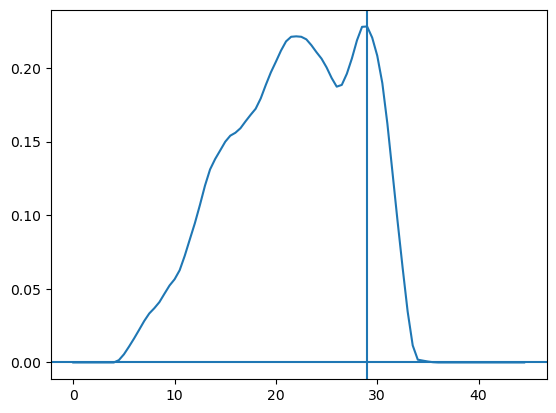

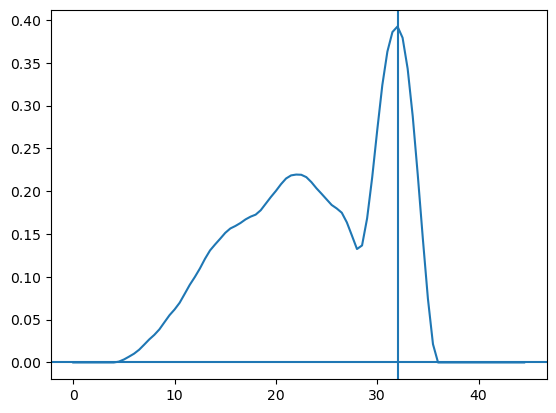

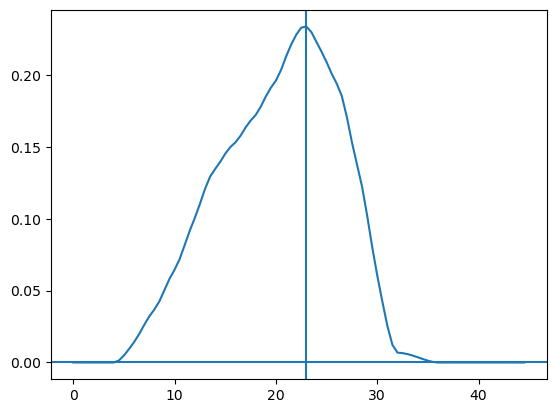

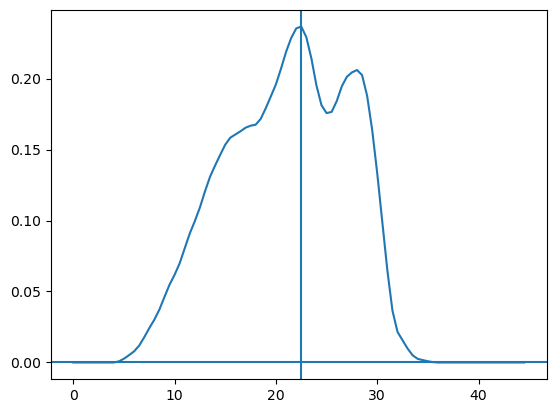

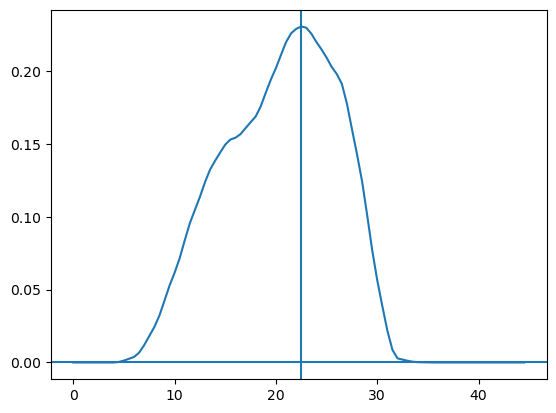

In [ ]:
bs = 500
n_channels = 1

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8
num_layers = 2
output_dim = 1  # Example: 5 classes

epochs = 10

model_args = (input_dim, hidden_dim, num_layers, output_dim)
model_class = temp_response_learner

coeffs_list = fit_on_subsets(temp_series_DE, NDVI_labels_DE, model_class, epochs, bs, model_args, savename_prefix = 'KFold', freeze_params=True, loss='BCE', bce=True, CNN=False)

23.0


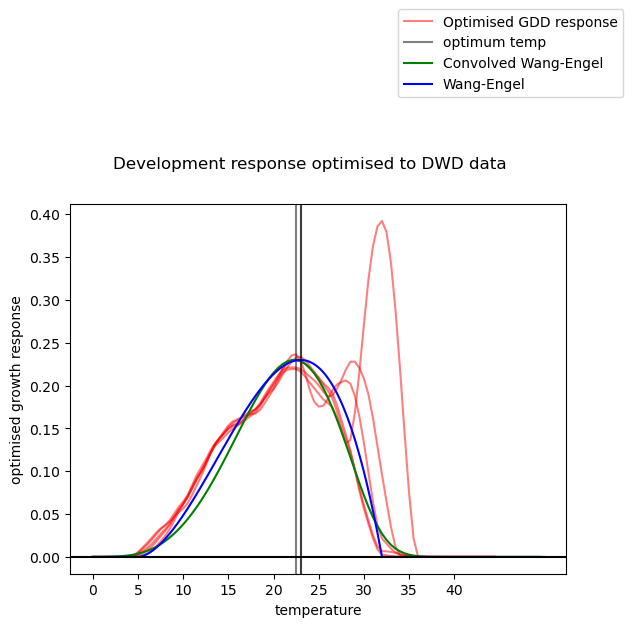

In [92]:
table = vec_expint(7, 23.5, 30, np.arange(0, 50, 0.5), 2.5, 5)
unconvolved = modelling_fctns.Wang_Engel_Temp_response(np.arange(0, 50, 0.1), 5, 23, 32)
def B_0(u):
    return ((1 - u**2)**2)*(u >= -1)*(u <= 1) #np.maximum((1/6)*(-(x**3) + 3*(x**2) - 3*x + 1), 0)
fig, ax = plt.subplots()
for i, co in enumerate(coeffs_list):
    def response(meantemp):
        resp = 0
        for i, coeff in enumerate(co):
            resp += torch.abs(coeff)*B_0(0.25*(meantemp - i*2))
        return resp
    if i == 2:
        ax.plot(np.arange(0, 45, 0.5), response(np.arange(0, 45, 0.5)), alpha = 0.5, color = 'red', label='Optimised GDD response')
        maxval = np.arange(0, 45, 0.5)[response(np.arange(0, 45, 0.5)).argmax()]
        print(maxval)
        ax.axvline(maxval, alpha = 0.5, color = 'black', label = 'optimum temp')
    else:
        ax.plot(np.arange(0, 45, 0.5), response(np.arange(0, 45, 0.5)), alpha = 0.5, color = 'red')
    
ax.plot(np.arange(0, 50, 0.5), table*0.23/table.max(), color = 'green', label = 'Convolved Wang-Engel')
maxval = np.arange(0, 50, 0.5)[table.argmax()]
ax.axvline(maxval, alpha = 0.5, color = 'black')
ax.plot(np.arange(0, 50, 0.1), unconvolved*0.23/unconvolved.max(), color = 'blue', label = 'Wang-Engel')
maxval = np.arange(0, 50, 0.1)[unconvolved.argmax()]
ax.axvline(maxval, alpha = 0.5, color = 'black')
ax.axhline(0, color = 'black')
ax.set_xlabel('temperature')
ax.set_ylabel('optimised growth response')
ax.set_xticks(np.arange(0, 45, 5))
fig.suptitle('Development response optimised to DWD data')
fig.legend(bbox_to_anchor = (1, 1.3))


In [9]:
ds_inputs_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\SSA_ML_fixed_photoperiod.csv')
skip = 1
numsteps = int(163 // skip)
NDVI_series_SSA = torch.Tensor(ds_inputs_SSA[[f'NDVI interpolated at day {skip*n}' for n in range(numsteps)]].values)#12
#NDVI_series_SSA = ((NDVI_series_SSA - NDVI_series_SSA.min(dim=1)[0].unsqueeze(1))/(NDVI_series_SSA.max(dim=1)[0] - NDVI_series_SSA.min(dim=1)[0]).unsqueeze(1))
temp_series_SSA = torch.Tensor(ds_inputs_SSA[[f'temperature at day {skip*n}' for n in range(numsteps)]].values)
#photoperiod_series_SSA = torch.Tensor((ds_inputs_SSA[[f'photoperiod at day {skip*n}' for n in range(numsteps)]] > 11).astype(int).values)#12
photoperiod_series_SSA = torch.Tensor(ds_inputs_SSA[[f'photoperiod at day {skip*n}' for n in range(numsteps)]].values)#12
day_series_SSA = torch.Tensor([[skip*n for n in range(numsteps)] for count in range(len(ds_inputs_SSA))])
year_series_SSA = torch.Tensor([ds_inputs_SSA['year'] for count in range(numsteps)]).T
id_series_SSA = torch.Tensor([ds_inputs_SSA['Stations_id'] for count in range(numsteps)]).T
temp_NDVI_series_SSA = torch.swapaxes(torch.stack((temp_series_SSA, photoperiod_series_SSA, NDVI_series_SSA, day_series_SSA, year_series_SSA, id_series_SSA)), 0, 1) #, photoperiod_series_SSA
NDVI_labels_SSA = torch.Tensor(ds_inputs_SSA[[f'dev stage at day {skip*n}' for n in range(numsteps)]].astype('int64').values)

0 38.876075744628906 38.650489807128906
5 38.33977508544922 38.11037826538086
10 38.30888748168945 38.0819091796875
15 37.76735305786133 37.536720275878906
20 37.7336311340332 37.504188537597656
25 37.643402099609375 36.955448150634766
30 37.146087646484375 36.920841217041016
35 36.59192657470703 36.36382293701172
40 36.545005798339844 36.31973648071289
45 35.98384475708008 35.75715637207031
50 35.414302825927734 35.186492919921875
55 35.34639358520508 34.609954833984375
60 34.76361083984375 34.02791976928711
65 34.110809326171875 33.433250427246094
70 33.065582275390625 32.8304443359375
75 32.44908905029297 32.036075592041016
80 31.298255920410156 31.055068969726562
85 30.12312126159668 29.83152961730957
90 28.75384521484375 28.14210319519043
95 26.69769859313965 26.188701629638672
100 24.281845092773438 23.51629638671875
105 21.038101196289062 19.952390670776367
110 16.17186164855957 14.725687980651855
115 8.919641494750977 6.813098907470703
120 2.011627674102783 1.1141560077667236
1

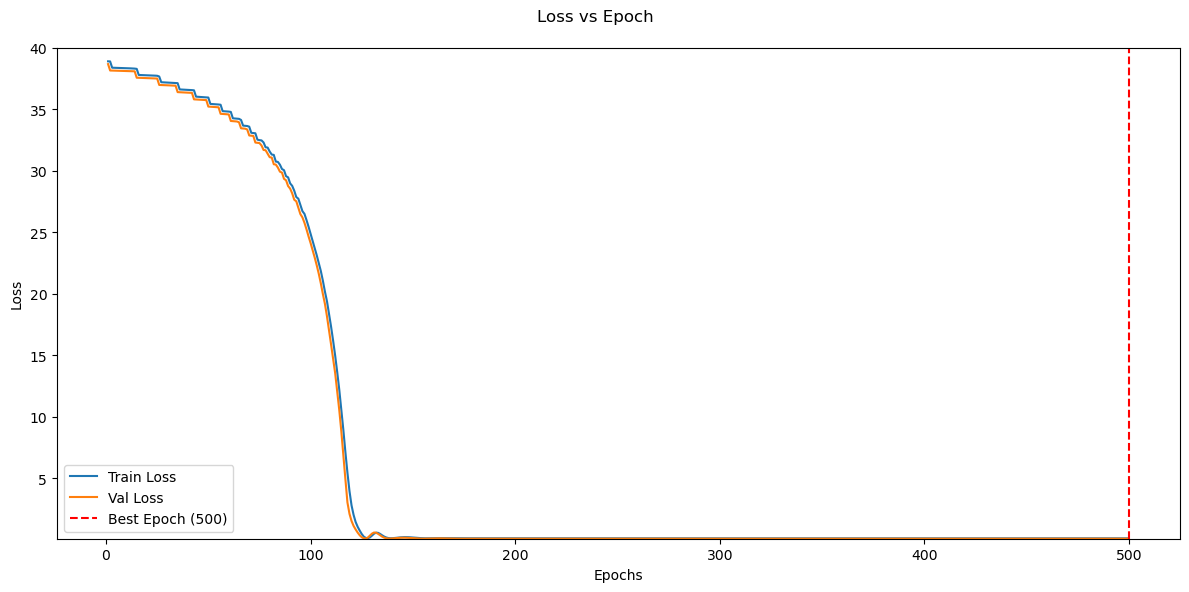

In [ ]:
bs = 500
n_channels = 1
#temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE)), 0, 1)#, NDVI_series_DE
#temp_NDVI_series_DE = torch.swapaxes(temp_NDVI_series_DE, 2, 1)
train_dl, val_dl = train_test_dl_from_tensors(temp_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.95)

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 32
num_layers = 2
output_dim = 1  # Example: 5 classes


save_name = 'temp_response_wang_SSA'

bce = True
CNN = False

model = temp_response_learner(input_dim, hidden_dim, num_layers, output_dim)
#for param in [model.p0, model.u0, model.u1, model.u2, model.u3]:#[model.u2]: #
#    param.requires_grad = False

# Loss function and optimizer
criterion = nn.BCELoss() #nn.NLLLoss()  # For multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

epochs = 500
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = CNN, bce=bce)

In [ ]:
epochs = 50
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = CNN, bce=bce)

u0 tensor([0.])
u1 tensor([0.])
u2 tensor([0.])
u3 tensor([0.])
u4 tensor([0.])
u5 tensor([-0.0880])
u6 tensor([0.0054])
u7 tensor([0.0717])
u8 tensor([0.0809])
u9 tensor([0.0691])
u10 tensor([0.0756])
u11 tensor([0.0968])
u12 tensor([0.0902])
u13 tensor([0.1131])
u14 tensor([0.1124])
u15 tensor([0.0840])
u16 tensor([3.6280e-05])
u17 tensor([0.])
u18 tensor([0.])
u19 tensor([0.])
p0 tensor([13.8375])
27.0


Text(0.5, 0.98, 'Development response optimised to SSA data')

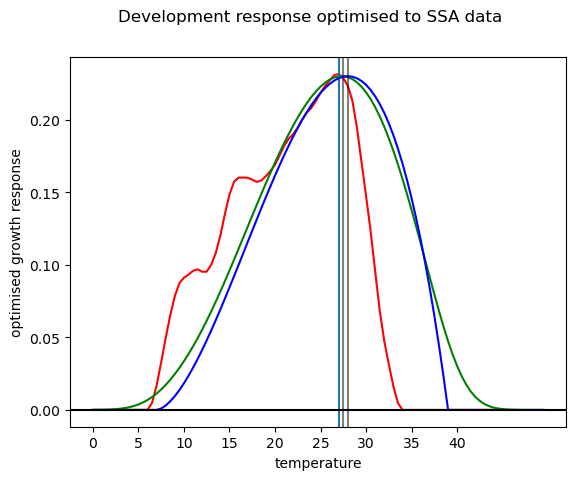

In [88]:
coeffs = []
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)
        coeffs.append(param.data)
coeffs = coeffs[:-4]

def B_0(u):
    return ((1 - u**2)**2)*(u >= -1)*(u <= 1) #np.maximum((1/6)*(-(x**3) + 3*(x**2) - 3*x + 1), 0)

def response(meantemp):
    resp = 0
    for i, coeff in enumerate(coeffs):
        resp += torch.abs(coeff)*B_0(0.25*(meantemp - i*2))
    return resp
    
fig, ax = plt.subplots()
ax.plot(np.arange(0, 45, 0.5), response(np.arange(0, 45, 0.5)), color = 'red', label = 'empirical response')
maxval = np.arange(0, 45, 0.5)[response(np.arange(0, 45, 0.5)).argmax()]
print(maxval)
ax.axvline(maxval)
ax.plot(np.arange(0, 50, 0.5), table*0.23/table.max(), color = 'green', label = 'Convolved Wang-Engel')
maxval = np.arange(0, 50, 0.5)[table.argmax()]
ax.axvline(maxval, alpha = 0.5, color = 'black')
ax.plot(np.arange(0, 50, 0.5), unconvolved*0.23/unconvolved.max(), color = 'blue', label = 'Wang-Engel')
maxval = np.arange(0, 50, 0.5)[unconvolved.argmax()]
ax.axvline(maxval, alpha = 0.5, color = 'black', label = 'optimum temperature')
ax.axhline(0, color = 'black')
ax.set_xlabel('temperature')
ax.set_ylabel('optimised growth response')
ax.set_xticks(np.arange(0, 45, 5))
fig.suptitle('Development response optimised to SSA data')

In [ ]:
temp_NDVI_series_SSA = torch.swapaxes(torch.stack((temp_series_SSA, photoperiod_series_SSA, NDVI_series_SSA, day_series_SSA)), 0, 1)
train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(temp_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.1)
plot_from_saved(save_name, model, val_dl, method = 'regression', bce=bce, CNN=CNN)#

In [43]:
class problist_square_loss(nn.Module):
    def __init__(self):
        super(problist_square_loss, self).__init__()
    def forward(self, logits, targets):
        discrepancy = (targets - logits)**2
        #print(discrepancy[0, :])
        #print((discrepancy.sum(dim=1)**2)[0])
        return (discrepancy.sum(dim=1)**2).mean()

In [44]:
class nn_temp_response(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, KG=True):
        super(nn_temp_response, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim
        self.KG = KG

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=False) # batch_first handles input shape (batch, seq, features)
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.layer1 = nn.Linear(hidden_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.layer4= nn.Linear(hidden_dim, hidden_dim)
        self.layer5 = nn.Linear(hidden_dim, hidden_dim)
        self.layer6= nn.Linear(hidden_dim, hidden_dim)
        self.layer7 = nn.Linear(hidden_dim, hidden_dim)
        self.layer8 = nn.Linear(hidden_dim, hidden_dim)
        self.layer9 = nn.Linear(hidden_dim, hidden_dim)
        self.layer10= nn.Linear(hidden_dim, hidden_dim)
        self.layer11 = nn.Linear(hidden_dim, hidden_dim)
        self.layer12 = nn.Linear(hidden_dim, hidden_dim)
        self.layer13= nn.Linear(hidden_dim, hidden_dim)
        self.layer14 = nn.Linear(hidden_dim, hidden_dim)
        self.layer15 = nn.Linear(hidden_dim, hidden_dim)
        self.layer16 = nn.Linear(hidden_dim, hidden_dim)
        self.layer17 = nn.Linear(hidden_dim, hidden_dim)
        self.layer18 = nn.Linear(hidden_dim, hidden_dim)
        self.layers_list = [self.input_layer, self.layer1, self.layer2, self.layer3,
                            self.layer4, self.layer5, self.layer6,
                            self.layer7, self.layer8, self.layer9,
                            self.layer10, self.layer11, self.layer12,
                            self.layer13, self.layer14, self.layer15,
                            self.layer16, self.layer17, self.layer18]
        self.fc = nn.Linear(hidden_dim, output_dim)  # Fully connected layer for classification
        self.input_dim = input_dim
        self.sig = nn.Sigmoid()

        self.activation = nn.LeakyReLU(negative_slope=0.01)

        self.u0 = torch.nn.Parameter(torch.Tensor([200])) #Now TTR
        self.u1 = torch.nn.Parameter(torch.Tensor([0])) #not used
        self.u2 = torch.nn.Parameter(torch.Tensor([0])) # not used
        self.u3 = torch.nn.Parameter(torch.Tensor([0])) #not used
        self.u4 = torch.nn.Parameter(torch.Tensor([10]))

        self.p0 = torch.nn.Parameter(torch.Tensor([13]))
        

    def forward(self, x0):
        x = x0[:, :, :self.input_dim]
        original_temp = x0[:, :, [0]]
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device) # Initialize hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device) # Initialize cell state
        # Apply Wang Engel
        T_min = 9 + 8*(torch.tanh(self.u1)) - 4 #was 2*
        T_opt = 28 + 8*(torch.tanh(self.u2)) - 4 #was 3*
        T_max = 39 + 2*torch.tanh(self.u3) - 2 #was 1*
        alpha = np.log(2)/torch.log( (T_max - T_min)/(T_opt - T_min) )
        beta = 1
        #print(x.shape)
        #print(T_min, T_opt, T_max)
        #print(alpha)
        #print(((2*(x - T_min)*(x >= T_min))**alpha))
        if self.KG:
            x[:, :, 0] = ( ( ((2*(x[:, :, 0] - T_min)*(x[:, :, 0] >= T_min))**alpha)*((T_opt - T_min)**alpha) - (((x[:, :, 0] - T_min)*(x[:, :, 0] >= T_min))**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta
        #x = torch.nan_to_num(x)
        #x = x*(x >= T_min)*(x<= T_max)
        #print(x)
        #print(x, x.shape)
        # Make cumulative
        if self.input_dim >= 3 and self.KG:
            x[:, :, 1] = 0.5*(1 + torch.tanh(2*(x[:, :, 1] - self.p0)))
        # Forward pass through LSTM
        #x = torch.swapaxes(x, 1, 2)
        #for i, linlayer in enumerate([self.input_layer, self.layer1, self.layer2, self.layer3, 
        #                              self.layer4, self.layer5, self.layer6,
        #                              self.layer7, self.layer8, self.layer9,
        #                              self.layer10, self.layer11, self.layer12]):
        for i, linlayer in enumerate(self.layers_list[:self.num_layers]):
            #print(i)
            #print(x.shape)
            #print(conv)
            x = linlayer(x)
            x = self.activation(x)
            #x = x[:, :, :-conv.padding[0]]
        #torch.nn.init.xavier_uniform(self.fc.weight)
        # Get the hidden state of the last time step
        # output[:, -1, :] is more efficient for batch_first=True
        #last_hidden = output[:, -1, :] # (batch, hidden_dim)
        #print(self.fc(output))
        
        # Classify all layers using fully connected layer
        out_space = torch.abs(self.fc(x))*(original_temp >5)# make sure it is non-neg and 0 for low temps (batch, output_dim)
        out_space = self.u4*torch.cumsum(out_space, dim=1) #x[:, :, 0] = self.u0*torch.cumsum(x[:, :, 0], dim = 1)
        if self.output_dim == 1:
            out_scores = self.sig(out_space - self.u0)
        else:
            out_scores = F.log_softmax(out_space, dim=2)
        #print(out_scores[0, :, :])
        #print(out_scores[0, :])
        return out_scores

In [23]:
print(model.u0)

Parameter containing:
tensor([20.])


In [88]:
x = temp_NDVI_series_DE[:10, :, :3]
y = temp_NDVI_series_DE[:10, :, [0]]

In [89]:
(y > 5)*x

tensor([[[1.1808e+01, 1.2635e+01, 1.2386e+01],
         [1.6744e+01, 1.6067e+01, 1.4142e+01],
         [8.3367e+00, 9.2841e+00, 1.0174e+01],
         [1.5317e+01, 1.5383e+01, 1.5450e+01],
         [-0.0000e+00, -0.0000e+00, -0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [2.0040e+03, 2.0040e+03, 2.0040e+03],
         [7.5040e+03, 7.5040e+03, 7.5040e+03]],

        [[6.5733e+00, 8.0332e+00, 7.7053e+00],
         [9.7469e+00, 1.1963e+01, 1.0145e+01],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.4767e+01, 1.4833e+01, 1.4917e+01],
         [-0.0000e+00, -0.0000e+00, -0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [2.0050e+03, 2.0050e+03, 2.0050e+03],
         [7.5040e+03, 7.5040e+03, 7.5040e+03]],

        [[5.8068e+00, 5.7121e+00, 9.5844e+00],
         [8.1602e+00, 9.6998e+00, 1.6149e+01],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.4383e+01, 1.4450e+01, 1.4517e+01],
         [-0.0000e+00, -0.0000e+00, -0.0000e+00],


In [ ]:
bs = 250
n_channels = 4

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 16
num_layers = 4
output_dim = 1  # Example: 5 classes
bce = True
CNN = False
KG = False

epochs = 2500
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
k_folds = 5
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG)

model_class = nn_temp_response

loss_values_raw, R2s_raw, Biases_raw, Variances_raw = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, model_args, savename_prefix = 'KFold', freeze_params=True, loss='BCE', bce=bce, CNN=CNN, lr = 0.001)

Fold 1
Loss: 0.1000269278883934
Fold 2


KeyboardInterrupt: 

In [ ]:
score = np.mean(loss_values_raw)
score_stde = np.std(loss_values_raw)/np.sqrt(5)
R2_score = np.mean(R2s_raw)
R2_stde = np.std(R2s_raw)/np.sqrt(5)
Bias_score = np.mean(np.array(Biases_raw)**2)
Bias_stde = np.std(np.array(Biases_raw)**2)/np.sqrt(5)
Variance_score = np.mean(Variances_raw)
Variance_stde = np.std(Variances_raw)/np.sqrt(5)
print(f'#### simple nn model SSA ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}\nBias {Bias_score} +/- {Bias_stde}\nVariance {Variance_score} +/- {Variance_stde}')

In [14]:
loss_values_outlier = np.array(loss_values_raw)[[0, 1, 3, 4]]
R2s_outlier = np.array(R2s_raw)[[0, 1, 3, 4]]
Biases_outlier = np.array(Biases_raw)[[0, 1, 3, 4]]
Variances_outlier = np.array(Variances_raw)[[0, 1, 3, 4]]
score = np.mean(loss_values_outlier)
score_stde = np.std(loss_values_outlier)/np.sqrt(5)
R2_score = np.mean(R2s_outlier)
R2_stde = np.std(R2s_outlier)/np.sqrt(5)
Bias_score = np.mean(np.array(Biases_outlier)**2)
Bias_stde = np.std(np.array(Biases_outlier)**2)/np.sqrt(5)
Variance_score = np.mean(Variances_outlier)
Variance_stde = np.std(Variances_outlier)/np.sqrt(5)
print(f'#### simple nn model ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}\nBias {Bias_score} +/- {Bias_stde}\nVariance {Variance_score} +/- {Variance_stde}')

#### simple nn model ####
loss 0.08158170132949823 +/- 0.0011735902870786945
R2 0.539517268538475 +/- 0.009512910996988278
Bias 1.4095807075500488 +/- 0.4881840389611978
Variance 69.87857913970947 +/- 1.9365423397382626


In [16]:
score = np.mean(loss_values_raw)
score_stde = np.std(loss_values_raw)/np.sqrt(5)
R2_score = np.mean(R2s_raw)
R2_stde = np.std(R2s_raw)/np.sqrt(5)
Bias_score = np.mean(np.array(Biases_raw)**2)
Bias_stde = np.std(np.array(Biases_raw)**2)/np.sqrt(5)
Variance_score = np.mean(Variances_raw)
Variance_stde = np.std(Variances_raw)/np.sqrt(5)
print(f'#### simple nn model ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}\nBias {Bias_score} +/- {Bias_stde}\nVariance {Variance_score} +/- {Variance_stde}')

#### simple nn model ####
loss 0.0857873895036034 +/- 0.0017501291191818161
R2 0.5025057911872863 +/- 0.03304838901787813
Bias 5.320456504821777 +/- 2.65924510467014
Variance 65.17378997802734 +/- 2.6935101650037243


In [15]:
bs = 250
n_channels = 4

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8
num_layers = 4
output_dim = 1  # Example: 5 classes
bce = True
CNN = False
KG = False

epochs = 2500
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
k_folds = 5
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG)

model_class = nn_temp_response

loss_values_raw, R2s_raw, Biases_raw, Variances_raw = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, model_args, savename_prefix = 'KFold', freeze_params=True, loss='BCE', bce=bce, CNN=CNN, lr = 0.001)

Fold 1
Loss: 0.10632183402776718
Fold 2
Loss: 0.10671341419219971
Fold 3
Loss: 0.07519201934337616
Fold 4
Loss: 0.09973899275064468
Fold 5
Loss: 0.09799212962388992


In [16]:
score = np.mean(loss_values_raw)
score_stde = np.std(loss_values_raw)/np.sqrt(5)
R2_score = np.mean(R2s_raw)
R2_stde = np.std(R2s_raw)/np.sqrt(5)
Bias_score = np.mean(np.array(Biases_raw)**2)
Bias_stde = np.std(np.array(Biases_raw)**2)/np.sqrt(5)
Variance_score = np.mean(Variances_raw)
Variance_stde = np.std(Variances_raw)/np.sqrt(5)
print(f'#### simple nn model SSA ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}\nBias {Bias_score} +/- {Bias_stde}\nVariance {Variance_score} +/- {Variance_stde}')

#### simple nn model SSA ####
loss 0.1493362158536911 +/- 0.054862736700971436
R2 0.4223050832748413 +/- 0.06124715833323278
Bias 3.0792195796966553 +/- 1.7015497732485039
Variance 74.30063247680664 +/- 10.535685162350985


In [19]:
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
epochs = 3000
KG = False
regression = False
bs = 500
n_channels = 4

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8
num_layers = 4
output_dim = 1 
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG)
loss_values, R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs = K_fold_crossval(5, train_ds, nn_temp_response, epochs, bs, model_args, lr = 0.01, loss = 'MSE', CNN=False, bce=True, custom_loss=criterion, DTF = False, obs_method=False)

Fold 1
Loss: 0.08006106317043304
torch.Size([51, 163]) torch.Size([51, 163, 1])
Fold 2
Loss: 0.08299506455659866
torch.Size([51, 163]) torch.Size([51, 163, 1])
Fold 3
Loss: 0.091669462621212
torch.Size([51, 163]) torch.Size([51, 163, 1])
Fold 4
Loss: 0.08720815926790237
torch.Size([51, 163]) torch.Size([51, 163, 1])
Fold 5
Loss: 0.0792701467871666
torch.Size([50, 163]) torch.Size([50, 163, 1])


In [35]:
err_df = make_error_df(R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, 'accumulated NN response', 'SSA', 'Transfer DE to SSA')

In [37]:
error_df_full = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\important_results\\error_df.csv')
err_df_full = pd.concat([error_df_full, err_df], ignore_index=True)
err_df_full.drop(['Unnamed: 0'], axis = 1, inplace = True)
err_df_full.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\important_results\\error_df.csv')

In [39]:
ds_inputs_SSA['observed time to beginning of flowering'].std()

12.342406717455804

0 0.20070478320121765 0.1972217857837677
5 0.17222975194454193 0.26452574133872986
10 0.1203250139951706 0.21172836422920227
15 0.1254911869764328 0.13188336789608002
20 0.10819168388843536 0.10779127478599548
25 0.10717657953500748 0.12595246732234955
30 0.10609320551156998 0.1459871083498001
35 0.10350611060857773 0.13650380074977875
40 0.10435164719820023 0.12099400162696838
45 0.10372642427682877 0.11523743718862534
50 0.10306055843830109 0.11556493490934372
55 0.10298377275466919 0.11853209882974625
60 0.10287643224000931 0.1212286576628685
65 0.1025882214307785 0.12190330028533936
70 0.10247145593166351 0.12152165174484253
75 0.10224862396717072 0.12180918455123901
80 0.10206149518489838 0.1208568811416626
85 0.10182983428239822 0.11823616921901703
90 0.10154758393764496 0.1155490130186081
95 0.10090300440788269 0.13161486387252808
100 0.10082988440990448 0.10060412436723709
105 0.10111568123102188 0.10539599508047104
110 0.10087910294532776 0.10889188200235367
115 0.099609002470

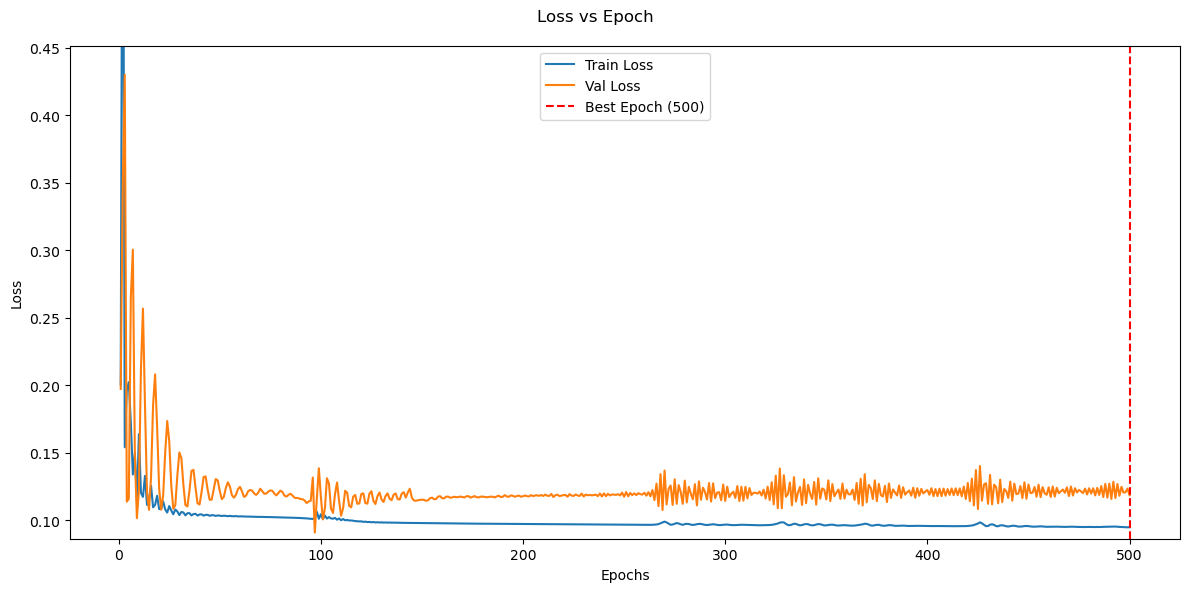

In [ ]:
bs = 500
n_channels = 5
#temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE, NDVI_series_DE)), 0, 1) #photoperiod_series_DE,
#temp_NDVI_series_DE = torch.swapaxes(temp_NDVI_series_DE, 2, 1)
train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.99)

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 16
num_layers = 4
output_dim = 1  # Example: 5 classes
KG = False

save_name= 'NN_response_SSA_no_day3'#'NN_response_DE'

model = nn_temp_response(input_dim, hidden_dim, num_layers, output_dim, KG = KG)
for param in [model.u0]: #[model.u1, model.u2, model.u3]:
    param.requires_grad = False

# Loss function and optimizer
criterion = nn.BCELoss() # nn.NLLLoss() # nn.BCELoss() #  # For multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 500
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = False, bce=True)

torch.Size([251, 163]) torch.Size([251, 163, 1])
R^2 value for model: 0.532931923866272
Bias: 0.042918819934129715
Variance of modelled values: 77.2651596069336


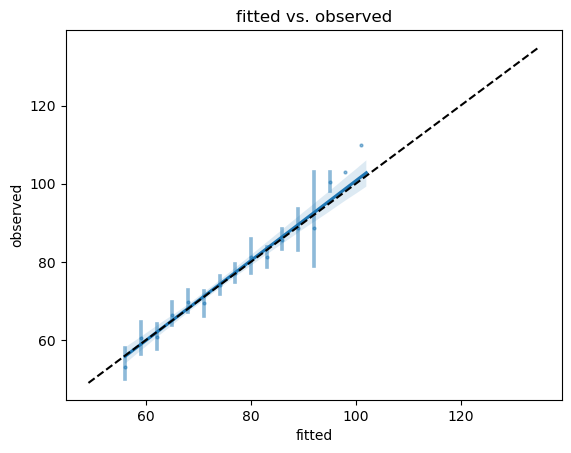

In [133]:
plot_from_saved(save_name, model, train_dl, method = 'regression', bce=True, CNN=False)#

In [134]:
save_name

'NN_response_SSA_no_day3'

0 140.0100013404812 79.87217658441989
5 89.85464719529976 60.775310928554575
10 90.87592089419746 58.30968183805994
15 71.24533745045095 58.27766787186118
20 72.75495378709901 56.856878689089555
25 71.70383217910496 58.09739474463322
30 73.8651432943706 64.81202451185065
35 71.23297769695341 56.59630398103905
40 71.20869892073596 55.71152070650651
45 69.15200162829302 67.49567191493067


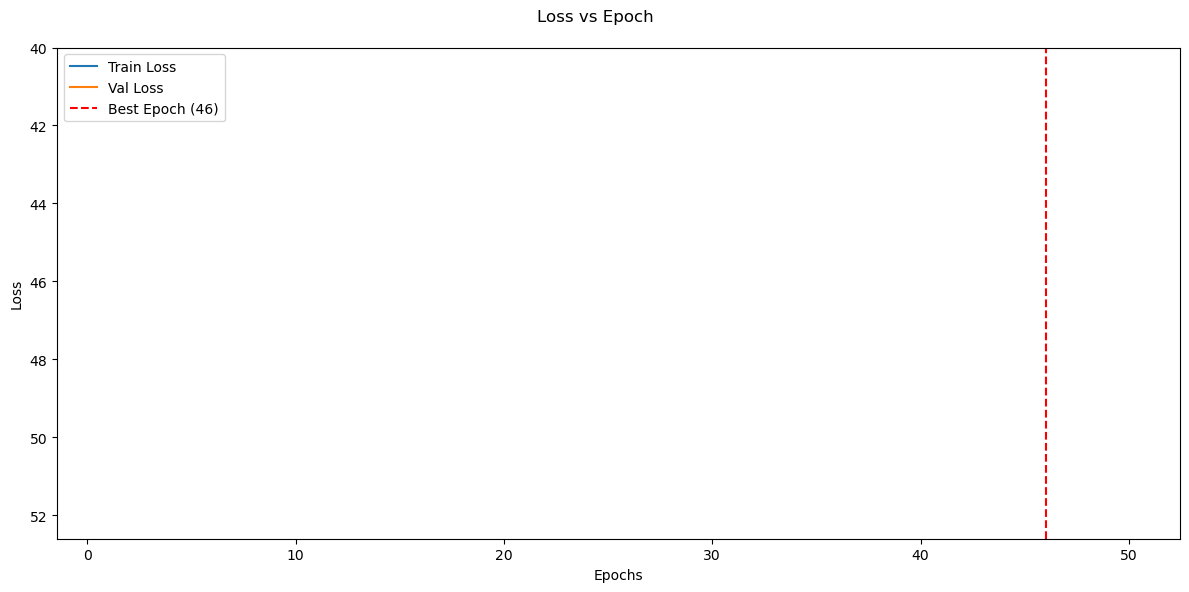

In [52]:
bs = 500
n_channels = 5
#temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE, NDVI_series_DE)), 0, 1) #photoperiod_series_DE,
#temp_NDVI_series_DE = torch.swapaxes(temp_NDVI_series_DE, 2, 1)
#train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels, train_proportion=0.8)
train_dl, val_dl = train_test_dl_by_year(temp_NDVI_series_DE, NDVI_labels_DE, test_years = [2022, 2023, 2024], year_column = -2, bs = bs, n_channels = n_channels, train_proportion=0.8)
input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8#day2 -> 8#day -> 16 #day3 ->4
num_layers = 8#day3 -> 8
output_dim = 1  # Example: 5 classes
KG = False

save_name= 'NN_response_DE_no_day5'#'NN_response_DE'

model = nn_temp_response(input_dim, hidden_dim, num_layers, output_dim, KG = KG)
for param in [model.u0, model.u4]: #[model.u1, model.u2, model.u3]:
    param.requires_grad = False

# Loss function and optimizer
criterion = nn.BCELoss() # nn.NLLLoss() # nn.BCELoss() #  # For multi-class classification
criterion = problist_square_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 50
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = False, bce=True)

0 75.45345978923382 60.34364424520017
5 76.41149509813702 67.91208019144175
10 79.82674916139905 93.11507824970838
15 67.50074595926243 57.229320128914885
20 72.90265138280556 55.89584771027031
25 69.63979791810851 57.24254336853627
30 69.18970425218477 55.90380017743364
35 77.83069450258165 55.58332656830373
40 73.50829431801414 55.425083182883874
45 68.26317715797937 56.95381590238021


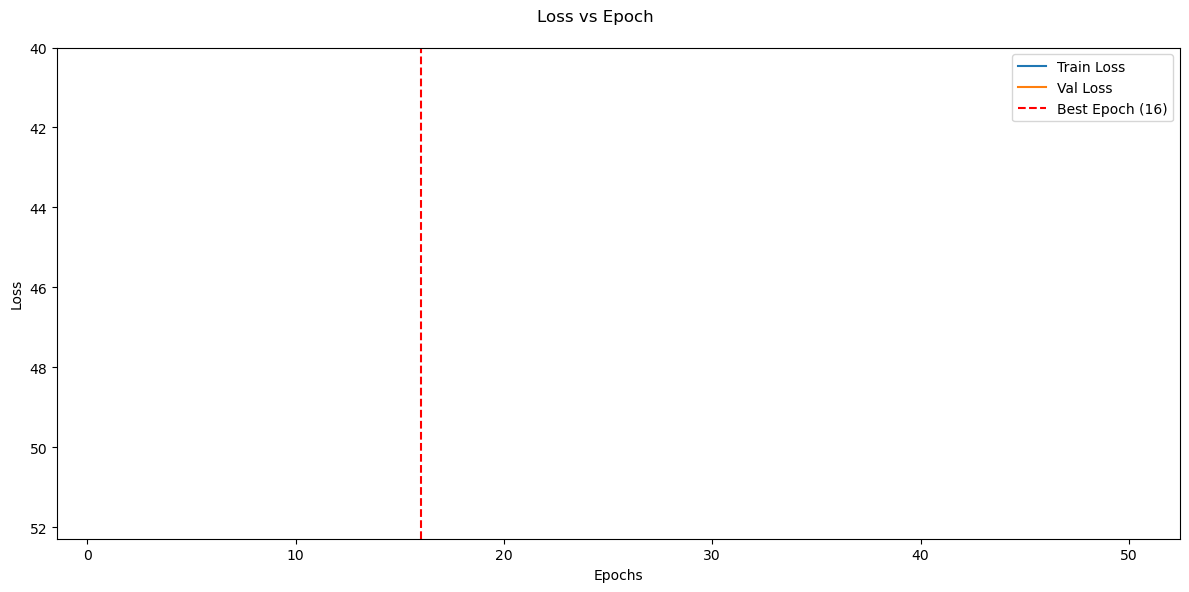

In [56]:
epochs = 50
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = False, bce=True)

OrderedDict([('u0', tensor([200.])), ('u1', tensor([0.])), ('u2', tensor([0.])), ('u3', tensor([0.])), ('u4', tensor([10.])), ('p0', tensor([13.])), ('lstm.weight_ih_l0', tensor([[-0.1000, -0.1738, -0.2096,  0.1330,  0.1507],
        [-0.3041, -0.2579,  0.3369, -0.3107,  0.3110],
        [ 0.0267,  0.1795,  0.1707,  0.2742,  0.0611],
        [-0.0932,  0.0389,  0.0410,  0.0393,  0.3497],
        [-0.0507,  0.3470, -0.0163, -0.2825,  0.3299],
        [-0.2648, -0.2246, -0.1187,  0.1120, -0.3077],
        [ 0.0353, -0.2322, -0.0992,  0.3017,  0.2417],
        [ 0.2481,  0.1774, -0.0293, -0.3412, -0.0766],
        [ 0.0403, -0.2103, -0.3493, -0.1671,  0.0716],
        [-0.0171, -0.2582,  0.3437,  0.0791, -0.1103],
        [-0.3084, -0.0393, -0.1270,  0.1007, -0.0092],
        [ 0.1781,  0.0358, -0.1770, -0.2582,  0.1764],
        [ 0.0819,  0.0239,  0.2224, -0.2487, -0.1562],
        [-0.3414,  0.1974, -0.3163,  0.0342,  0.0958],
        [-0.1855,  0.0181, -0.2170, -0.1686, -0.3438],
    

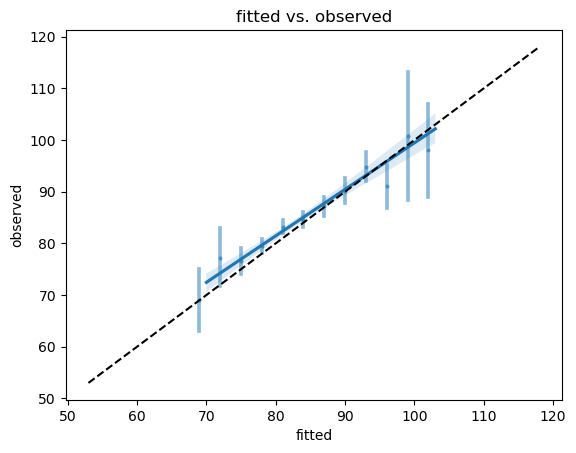

In [57]:
#save_name= 'NN_response_DE_no_day4'
plot_from_saved(save_name, model, val_dl, method = 'regression', bce=True, CNN=False)#

In [40]:
def get_comp_frame(savename, model, dl, bce=False, CNN=False, title = 'fitted vs. observed', MMD = False):
    model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
    model_path = os.path.join(model_dir, savename + ".pt")
    checkpoint = torch.load(model_path, weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    TS_model = model
    list_logs = []
    list_observed = []
    for xb, yb in dl:
        with torch.no_grad():
            if CNN:
                if MMD:
                    list_logs.append(TS_model(xb)[0])
                else:
                    list_logs.append(TS_model(xb))
            else:
                list_logs.append(TS_model(xb.transpose(1, 2)))
            #print(TS_model(xb.transpose(1, 2)))
        list_observed.append(yb)
    logs = torch.squeeze(torch.cat(list_logs))
    print(logs.shape, torch.cat(list_logs, dim=0).shape)
    if bce:
        fitted = torch.round(logs)
    else:
        fitted = torch.argmax(logs, dim=2)
    L = fitted.shape[1]
    fitted_days = L - fitted.sum(dim=1)
    observed = torch.cat(list_observed)
    observed_days = L - observed.sum(dim=1)
    comparison_frame = pd.DataFrame({'fitted': fitted_days.numpy().squeeze(), 'observed': observed_days.numpy().squeeze()})
    return comparison_frame
    

In [18]:
cf = get_comparison_frame(save_name, model, val_dl, bce=True, CNN=False)#

In [20]:
cf['fitted'].std()

6.263402938842773

In [55]:
save_name= 'NN_response_DE_no_day2'#'NN_response_DE'
model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
model_path = os.path.join(model_dir, save_name + ".pt")
checkpoint = torch.load(model_path, weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [28]:
def forward_NN(self, x0):
    x = x0[:, :, :self.input_dim]
    original_temp = x0[:, :, [0]]
    for i, linlayer in enumerate(self.layers_list[:self.num_layers]):
        x = linlayer(x)
        x = self.activation(x)
        #print(x.shape)
    # Classify all layers using fully connected layer
    out_space = torch.abs(self.fc(x))*(original_temp >5)#*(x[:, :, [0]] >5) # (batch, output_dim)

    #print(out_scores.max())
    return out_space

In [29]:
temp_NDVI_series_DE[5, :, 50]

tensor([ 1.4361e+01,  1.9283e+01,  8.8329e+00,  1.6967e+01, -1.0938e-01,
         5.0000e+00,  2.0100e+03,  7.5040e+03])

In [30]:
(temp_NDVI_series_DE[:, 0, :] - temp_NDVI_series_DE[:, 2, :]).mean()

tensor(3.9975)

tensor(2.0073)
tensor(4.6437)
tensor(5.0247)
tensor(5.8098)
tensor(5.1525)
tensor(3.4988)
tensor(6.0636)
tensor(4.4404)
tensor(6.3490)
tensor(3.5249)


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_18856\2594083112.py:39: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  vals = np.array(vals).squeeze()


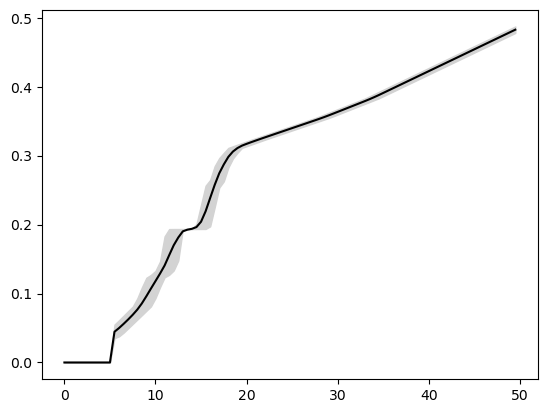

In [58]:
input_tensor = temp_NDVI_series_DE
input_x = torch.ones((1, 8, 100))
for vble_index in range(0, 5):
    input_x[0, vble_index, :] = input_tensor[:, vble_index, :].mean()#.quantile(0.75)
for i, T in enumerate(np.arange(0, 50, 0.5)):
    input_x[0, 0, i] = T
#    input_x[0, 1, i] = T + 5
#    input_x[0, 2, i] = T - 5
#for i, T in enumerate(np.linspace(-0.3, 0, 100)):#np.arange(-0.3, 0, 0.05)):
#    input_x[0, 4, i] = T
#    input_x[0, 4, i] = T + 0.05
#    input_x[0, 5, i] = T - 0.05
#for i, day in enumerate(np.arange(0, 100, 1)):
#    input_x[0, 5, i] = day
vals_list = []
for experiment_index in range(500):
    sample_index = np.random.randint(0, input_tensor.shape[0])
    day_index = 10#np.random.randint(0, temp_NDVI_series_DE.shape[2])
    input_x[0, 3, :] = input_tensor[sample_index, 3, day_index]
    input_x[0, 4, :] = input_tensor[sample_index, 4, day_index]
    input_x[0, 5, :] = input_tensor[sample_index, 5, day_index]
    temp_pert = np.abs(np.random.normal(0, 1)*5)
    temp_pert = input_tensor[sample_index, 1, day_index] - input_tensor[sample_index, 0, day_index]
    if experiment_index % 50 == 0:
        print(temp_pert)
    input_x[0, 1, :] = input_x[0, 0, :] + temp_pert
    input_x[0, 2, :] = input_x[0, 0, :] - temp_pert
    with torch.no_grad():
        vals = forward_NN(model, input_x.transpose(1, 2))
    vals_list.append(vals.numpy().squeeze())
for vble_index in range(3, 6):
    input_x[0, vble_index, :] = input_tensor[:, vble_index, :].mean()#.quantile(0.75)
input_x[0, 5, :] = day_index
temp_pert = 5#np.abs(np.random.normal(0, 1)*10)
input_x[0, 1, :] = input_x[0, 0, :] + temp_pert
input_x[0, 2, :] = input_x[0, 0, :] - temp_pert
with torch.no_grad():
    vals = forward_NN(model, input_x.transpose(1, 2))
vals = np.array(vals).squeeze()
vals = np.mean(np.array(vals_list), axis=0)
vals_spread = np.std(np.array(vals_list), axis=0)
vals_LQ = np.quantile(np.array(vals_list), 0.1, axis=0)
vals_UQ = np.quantile(np.array(vals_list), 0.9, axis=0)
fig, ax = plt.subplots()
#ax.fill_between(np.arange(0, 50, 0.5), vals - vals_spread, vals + vals_spread, color = 'lightgrey', label = 'spread due to other variables')
ax.fill_between(np.arange(0, 50, 0.5), vals_LQ, vals_UQ, color = 'lightgrey', label = 'spread due to other variables')
ax.plot(np.arange(0, 50, 0.5), vals, color = 'black', label = 'mean response')
#plt.plot(np.arange(0, 50, 0.5), np.array(vals).squeeze()*2)#np.linspace(-0.3, 0, 100)

Text(0.5, 1.0, 'Wang response functions with experimental parameters\nvs. neural network response')

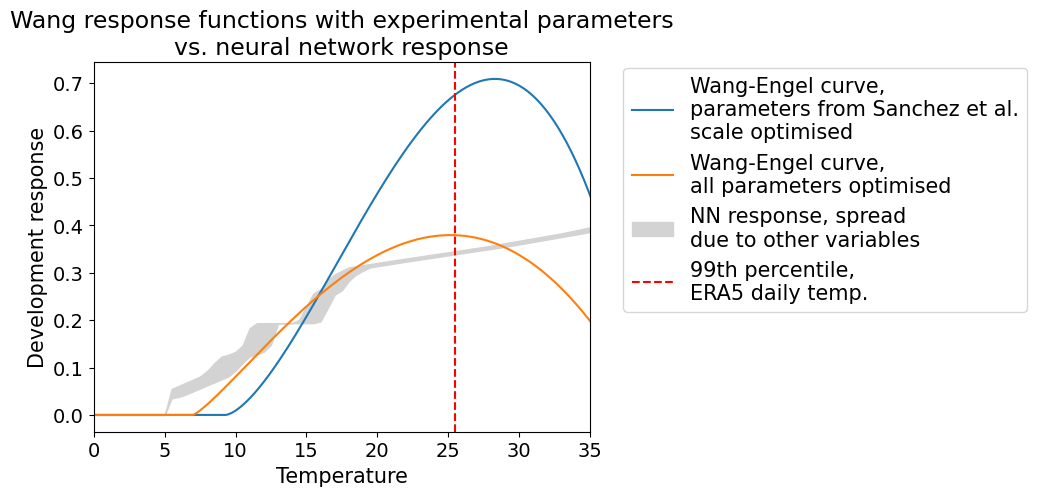

In [59]:
font_size = 15
fm_flowering_all_DE2 = [[[0.503004, 9.3, 28.3, 39.2]], 'ds_inputs_DE_reduced', 0]#[[[0.503004, 7.02058042, 27.00252239, 39.30655295]], 'ds_inputs_DE_reduced', 0]
x = fm_flowering_all_DE2[0][0]
x_0 = 0.708822
x_1 = 0.607894
#x_1 = 0.4
fm_flowering_all_DE = [[0.37934956, 7.0094127, 25.16467337, 39.17442218], 'ds_inputs_DE_reduced', 0]#[[ 0.37934956  7.0094127  25.16467337 39.17442218  2.5360532   4.80742285], 'ds_inputs_DE_reduced', 0]
table = vec_expint(x[1], x[2], x[3], np.arange(0, 50, 0.5), 8, 3)#, x[4], x[5])#x[2]
def response(meantemp):
    return x[0]*table[(np.round(meantemp/5, decimals = 1)*10).astype(int)]*(meantemp > 0)
xvals = np.arange(0, 50, 0.1)
fig, ax = plt.subplots()
ax.plot(xvals, x_0*modelling_fctns.Wang_Engel_Temp_response(xvals, fm_flowering_all_DE2[0][0][1], fm_flowering_all_DE2[0][0][2], fm_flowering_all_DE2[0][0][3]), label = 'Wang-Engel curve,\nparameters from Sanchez et al.\nscale optimised')#fm_flowering_all_DE2[0][0][0]
#ax.plot(np.arange(0, 50, 0.5), x_1*np.array(table), label = 'Convolved Wang-Engel curve,\nparameters from Sanchez et al.\nscale optimised')
ax.plot(xvals, fm_flowering_all_DE[0][0]*modelling_fctns.Wang_Engel_Temp_response(xvals, fm_flowering_all_DE[0][1], fm_flowering_all_DE[0][2], fm_flowering_all_DE[0][3]), label = 'Wang-Engel curve,\nall parameters optimised')
#ax.plot(np.arange(0, 50, 0.5), vals, label = 'Neural network response with\nother variables held constant')
#ax.fill_between(np.arange(0, 50, 0.5), vals - vals_spread , vals + vals_spread, color = 'lightgrey', label = 'NN response inc. spread\ndue to other variables')
ax.fill_between(np.arange(0, 50, 0.5), vals_LQ, vals_UQ, color = 'lightgrey', label = 'NN response, spread\ndue to other variables')
#ax.set_title('Convolution SD in box of 7, temp range in day of 6')

ax.axvline(np.quantile(ds_inputs_DE[[f't2m at day {n}' for n in range(150)]].values, 0.99), color = 'red', linestyle = '--', label = '99th percentile,\nERA5 daily temp.')
#ax.axvline(np.quantile(ds_inputs_DE[[f't2m at day {n}' for n in range(150)]].values, 0.05), color = 'red', linestyle = '--', label = '1st percentile,\nERA5 daily temp.')
#ax.axvline(ds_inputs_DE[[f't2m at day {n}' for n in range(150)]].values.max(), color = 'red', linestyle = ':', label = '99th percentile,\nERA5 daily temp.')
#ax.axvline(ds_inputs_DE[[f't2m at day {n}' for n in range(150)]].values.min(), color = 'red', linestyle = ':', label = '1st percentile,\nERA5 daily temp.')
#ax.axvline(ds_inputs_DE['t2m at day 88'].mean(), color = 'red', linestyle = ':', label = 'Mean temp at mean day of flowering')
#ax.axvline(28.3, color = 'k', linestyle = '--', label = 'optimal temp from\nSanchez et al.')
#ax.axvline(fm_flowering_all_DE[0][2], color = 'k', label = 'optimal temp from optimisation')
ax.set_xlim(0, 35)
ax.tick_params(axis='both', labelsize = font_size - 1)
ax.set_xlabel('Temperature', fontsize = font_size)
ax.set_ylabel('Development response', fontsize = font_size)
fig.legend(bbox_to_anchor=(1.6, 0.89), fontsize = font_size)
ax.set_title('Wang response functions with experimental parameters\nvs. neural network response', fontsize = font_size + 2)


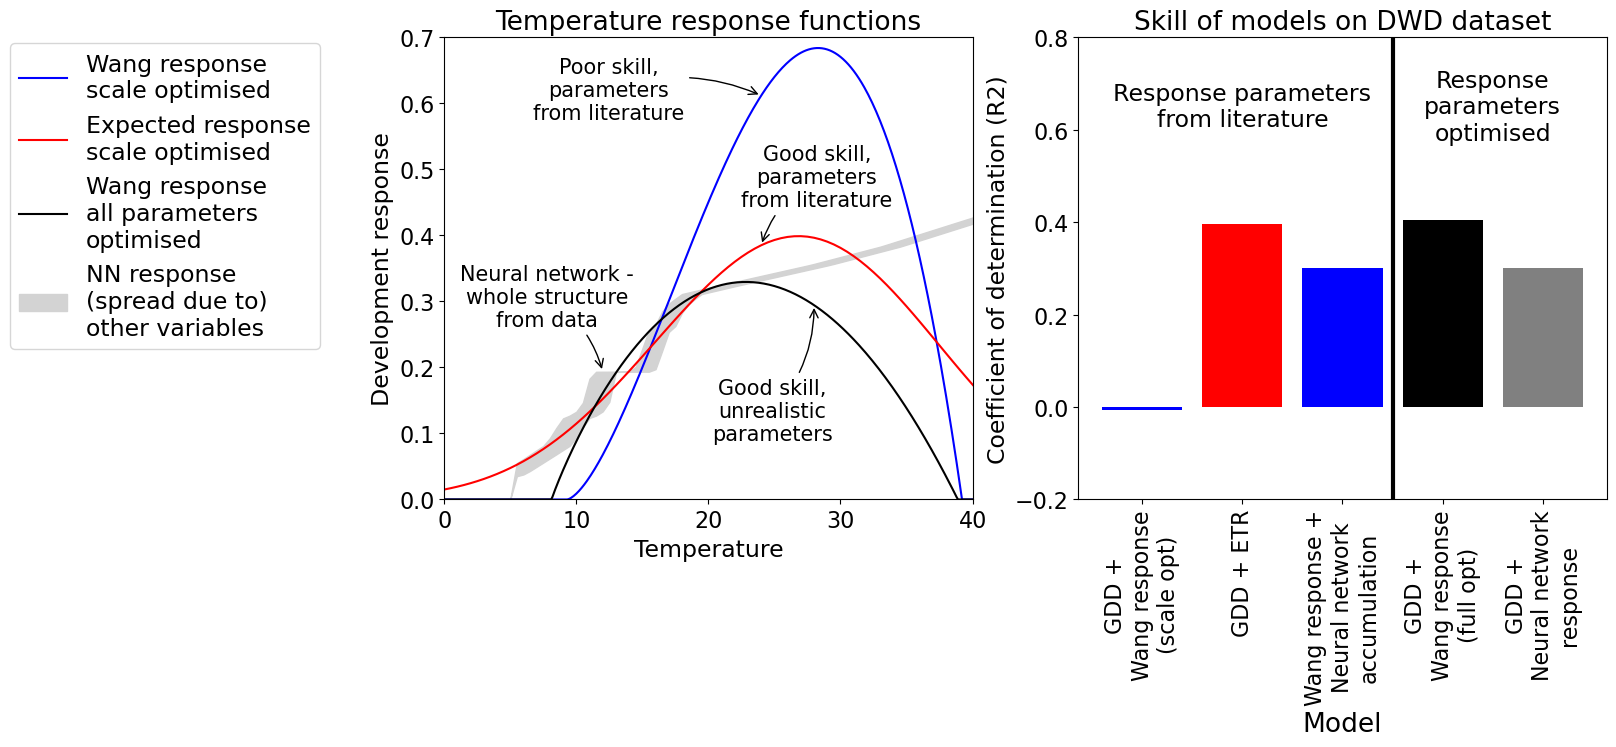

In [60]:
font_size = 17
x_1 = 0.684018
x_3 = 0.329584
x_0_conv =  0.587931
table = vec_expint(9.3, 28.3, 39.2, np.arange(0, 50, 0.5), 8, 3)#, x[4], x[5])#x[2]
fm_flowering_all_DE2 = [[[x_1, 9.3, 28.3, 39.2]], 'ds_inputs_DE_reduced', 0]#[[[0.503004, 7.02058042, 27.00252239, 39.30655295]], 'ds_inputs_DE_reduced', 0]
fm_flowering_all_DE = [[[x_3, 8.13380267, 22.83931163, 38.88095627], ds_inputs_DE, 0]]#[[[0.34525542, 7.00219008, 23.57229066, 39.02041395]], ds_inputs_DE, 0]
x = fm_flowering_all_DE2[0][0]
xvals = np.arange(0, 50, 0.1)
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
ax = axs[0]
ax.plot(xvals, x[0]*modelling_fctns.Wang_Engel_Temp_response(xvals, x[1], x[2], x[3]), label = 'Wang response\nscale optimised', color = 'blue')#linestyle = '-.', color = 'k'fm_flowering_all_DE2[0][0][0] \nSanchez parameters,
ax.plot(np.arange(0, 50, 0.5), x_0_conv*table, label = 'Expected response\nscale optimised', color = 'red')#\nSanchez parameters
ax.plot(xvals, fm_flowering_all_DE[0][0][0]*modelling_fctns.Wang_Engel_Temp_response(xvals, fm_flowering_all_DE[0][0][1], fm_flowering_all_DE[0][0][2], fm_flowering_all_DE[0][0][3]), 
        label = 'Wang response\nall parameters\noptimised', color='k')
ax.fill_between(np.arange(0, 50, 0.5), vals_LQ, vals_UQ, color = 'lightgrey', label = 'NN response\n(spread due to)\nother variables')
#ax.set_title('Convolution SD in box of 7, temp range in day of 6')
percentile_99 = np.quantile(ds_inputs_DE[[f't2m at day {n}' for n in range(150)]].values, 0.99)
percentile_1 = np.quantile(ds_inputs_DE[[f't2m at day {n}' for n in range(150)]].values, 0.01)
#ax.axvline(np.quantile(ds_inputs_DE[[f't2m at day {n}' for n in range(150)]].values, 0.99), color = 'k', linestyle = ':', label = '99th percentile,\nERA5 daily temp.')
#ax.axvline(np.quantile(ds_inputs_DE[[f't2m at day {n}' for n in range(150)]].values, 0.01), color = 'k', linestyle = '--', label = '1st percentile,\nERA5 daily temp.')
#ax.fill_betweenx([0, 0.7], [0, 0], [percentile_1, percentile_1], color = 'gray', alpha = 0.2, label = 'Temp. below/above\n1st/99th percentile\nof ERA5 data')
#ax.fill_betweenx([0, 0.7], [percentile_99, percentile_99], [50, 50], color = 'gray', alpha = 0.2)
#ax.axvline(ds_inputs_DE['t2m at day 88'].mean(), color = 'red', linestyle = ':', label = 'Mean temp at mean day of flowering')
#ax.axvline(28.3, color = 'k', linestyle = '--', label = 'optimal temp from\nSanchez et al.')
#ax.axvline(fm_flowering_all_DE[0][0][2], color = 'k', label = 'optimal temp from optimisation')
ax.set_xlim(0, 40)
ax.set_ylim(0, 0.7)
ax.tick_params(axis='both', labelsize = font_size - 1)
ax.set_xlabel('Temperature', fontsize = font_size)
ax.set_ylabel('Development response', fontsize = font_size)
fig.legend(bbox_to_anchor=(0.05, 0.89), fontsize = font_size)
ax.set_title('Temperature response functions', fontsize = font_size + 2)
conv_ylabel = x_0_conv*table[48]
conv_xlabel = np.arange(0, 50, 0.5)[48]
ax.annotate('Good skill,\nparameters\nfrom literature',
            xy=(conv_xlabel, conv_ylabel), xycoords='data',
            xytext=(40, 25), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3,rad=0.2"),
            horizontalalignment='center', verticalalignment='bottom',
            fontsize = font_size-2)
wang_ylabel = fm_flowering_all_DE[0][0][0]*modelling_fctns.Wang_Engel_Temp_response(28, fm_flowering_all_DE[0][0][1], fm_flowering_all_DE[0][0][2], fm_flowering_all_DE[0][0][3])
wang_xlabel = 28
ax.annotate('Good skill,\nunrealistic\nparameters',
            xy=(wang_xlabel, wang_ylabel), xycoords='data',
            xytext=(-30, -100), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3,rad=.2"),
            horizontalalignment='center', verticalalignment='bottom',
            fontsize = font_size-2)
sanchez_ylabel = x[0]*modelling_fctns.Wang_Engel_Temp_response(24, x[1], x[2], x[3])
sanchez_xlabel = 24
ax.annotate('Poor skill,\nparameters\nfrom literature',
            xy=(sanchez_xlabel, sanchez_ylabel), xycoords='data',
            xytext=(-110, -20), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3,rad=-.2"),
            horizontalalignment='center', verticalalignment='bottom',
            fontsize = font_size-2)
NN_ylabel = vals_UQ[24]
NN_xlabel = 12
ax.annotate('Neural network -\nwhole structure\nfrom data',
            xy=(NN_xlabel, NN_ylabel), xycoords='data',
            xytext=(-40, 30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3,rad=-.2"),
            horizontalalignment='center', verticalalignment='bottom',
            fontsize = font_size-2)
model_list = ['GDD +\nWang response\n(scale opt)', 'GDD + ETR', 'Wang response +\nNeural network\naccumulation', 'GDD +\nWang response\n(full opt)',  'GDD +\nNeural network\nresponse']
err_df = pd.DataFrame({
    'model': model_list,
    'R2': [-0.007274488791904732, 0.3971851248423798, 0.3, 0.404027147557559, 0.30066704750061035]})
ax = axs[1]
ax.bar(data=err_df, x='model', height='R2', color = ['blue', 'red', 'blue', 'k', 'gray'])
ax.tick_params(axis='both', labelsize = font_size - 1)
ax.tick_params(axis='x', rotation = 90)
ax.set_xlabel('Model', fontsize = font_size + 2)
ax.set_ylabel('Coefficient of determination (R2)', fontsize = font_size)
ax.axvline(2.5, color='k', linewidth = 3)
ax.set_ylim((-0.2, 0.8))
ax.annotate('Response parameters\nfrom literature',
            xy=(1, 0.65), xycoords='data',
            xytext=(0, 0), textcoords='offset pixels',
            horizontalalignment='center',
            verticalalignment='center', fontsize = font_size)
ax.annotate('Response\nparameters\noptimised',
            xy=(3.5, 0.65), xycoords='data',
            xytext=(0, 0), textcoords='offset pixels',
            horizontalalignment='center',
            verticalalignment='center', fontsize = font_size)
ax.set_title('Skill of models on DWD dataset', fontsize = font_size + 2)
fig.savefig('C:\\Users\\wlwc1989\\Documents\\paper 1\\iCropM plots\\iCropM_plot.png', bbox_inches='tight')

In [129]:
np.quantile(ds_inputs_DE[[f't2m at day {n}' for n in range(120)]].values, 0.01)

np.float64(6.6684328604979655)

<BarContainer object of 5 artists>

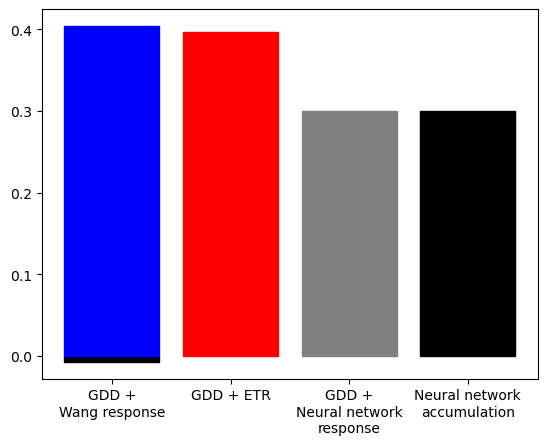

In [92]:
fig, ax = plt.subplots()
ax.bar(data=err_df, x='model', height='R2', color = ['k', 'red', 'blue', 'gray', 'k'], edgecolor = ['k', 'red', 'blue', 'gray', 'k'])

In [87]:
err_df

,model,R2
0,GDD +\nWang response,-0.007274
1,GDD + ETR,0.397185
2,GDD +\nWang response,0.404027
3,GDD +\nNeural network\nresponse,0.300667
4,Neural network\naccumulation,0.300000


In [15]:
#train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.01)
comparison_frame = get_comparison_frame(save_name, model, val_dl, bce=True, CNN=False, MMD=False, DTF = False, n_channels = n_channels, obs_method = False)

TypeError: get_comparison_frame() got an unexpected keyword argument 'MMD'

In [81]:
def plot_from_saved(savename, model, val_dl, method = 'regression', bce=False, CNN=False, title = 'fitted vs. observed', MMD=False):
    model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
    model_path = os.path.join(model_dir, savename + ".pt")
    checkpoint = torch.load(model_path, weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    #print(model.u4)
    #model.u4=nn.Parameter(torch.Tensor([0.02]))
    #print(model.u4)
    #print(checkpoint['model_state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if method == 'cumulative':
        plot_fitted_observed_cumulative(model, val_dl, bce=bce, CNN=CNN, title=title, MMD=MMD)
    elif method == 'regression':
        plot_fitted_observed_TS(model, val_dl, bce=bce, CNN=CNN, title=title, MMD=MMD)
    elif method == 'histogram':
        plot_fitted_observed_histogram(model, val_dl, bce=bce, CNN=CNN, title=title, MMD=MMD)

In [76]:
for xb, yb in val_dl_SSA:
    print(yb.shape)

torch.Size([252, 163])


torch.Size([252, 163]) torch.Size([252, 163, 1])
R^2 value for model: 0.28196239471435547
Bias: 0.5565648078918457
Variance of modelled values: 22.250215530395508


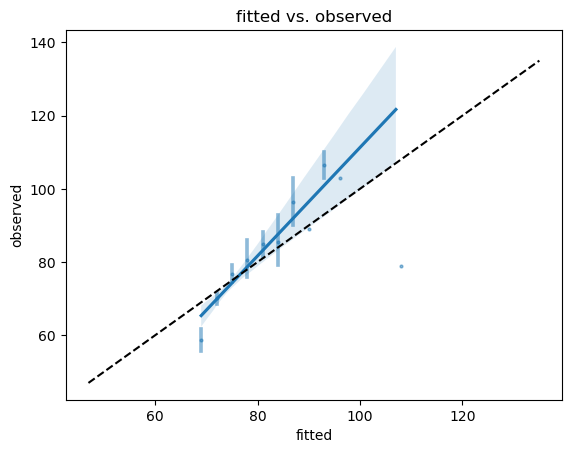

In [98]:
train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.01)
plot_from_saved('KFold4', model, val_dl_SSA, method = 'regression', bce=True, CNN=False)#

In [29]:
R2s = []
Biases = []
Variances = []

RMSEs = []
STDs = []
Corrs = []

Mins = []
LQs = []
Medians = []
UQs = []
Maxs = []

comparison_frame['Error'] = comparison_frame['observed'] - comparison_frame['fitted']

r2_score_model = r2_score(comparison_frame['observed'], comparison_frame['fitted'])
bias_model = (comparison_frame['Error']).mean()
variance = comparison_frame['fitted'].var()

RMSE = np.sqrt(np.mean((comparison_frame['Error'] - bias_model)**2))
STD = comparison_frame['fitted'].std() 
Corr = comparison_frame['observed'].corr(comparison_frame['fitted'])

RMSEs.append(RMSE)
STDs.append(STD)
Corrs.append(Corr)

Mins.append(comparison_frame['Error'].min())
LQs.append(comparison_frame['Error'].quantile(0.25))
Medians.append(comparison_frame['Error'].median())
UQs.append(comparison_frame['Error'].quantile(0.75))
Maxs.append(comparison_frame['Error'].max())

R2s.append(r2_score_model)
Biases.append(bias_model)
Variances.append(variance)

0 0.09037242921541684 0.10456027343441239
5 0.08992410350411305 0.1032807466722344
10 0.08961512309671998 0.102224383765817
15 0.08925422871609769 0.10115735964270858
20 0.0889349236885529 0.10146962047868235
25 0.08862703296483329 0.09941004666040211


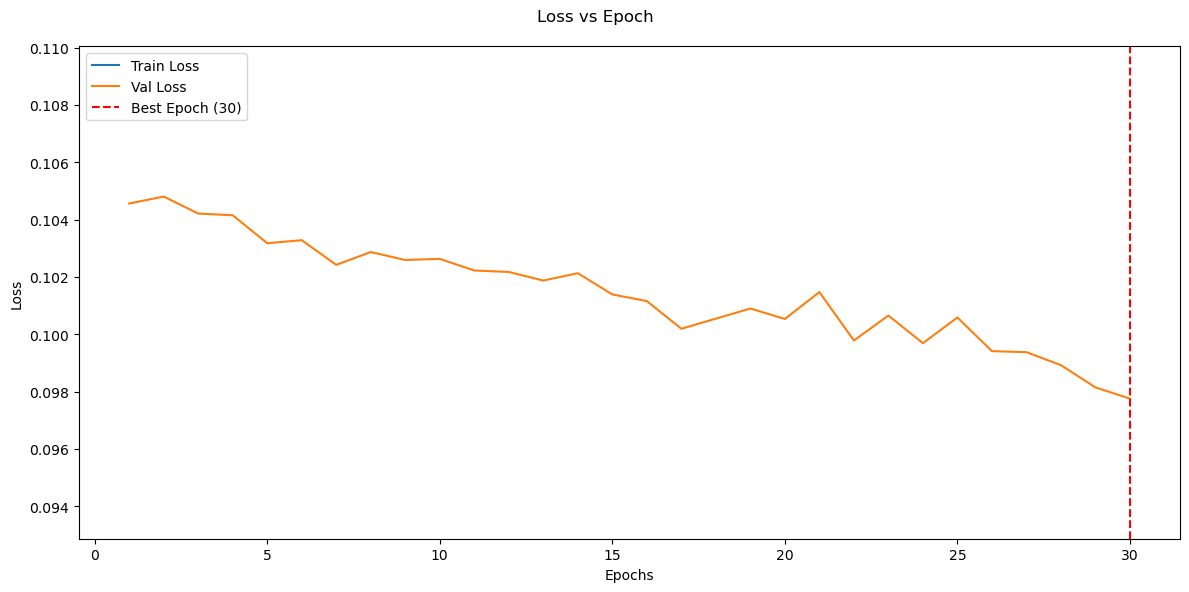

In [18]:
epochs = 30
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = False, bce=True)

OrderedDict([('u0', tensor([1.3818])), ('u1', tensor([0.])), ('u2', tensor([0.])), ('u3', tensor([0.])), ('u4', tensor([0.7990])), ('p0', tensor([13.])), ('lstm.weight_ih_l0', tensor([[-0.2404, -0.1111, -0.0454,  0.1936, -0.1655,  0.2254],
        [ 0.0169,  0.1593, -0.2032, -0.1482, -0.2339,  0.1009],
        [ 0.2236,  0.1397, -0.2136,  0.0487, -0.0030,  0.2439],
        [ 0.0247, -0.0894,  0.0249,  0.1936, -0.1072,  0.1596],
        [ 0.2204,  0.2266,  0.1290, -0.0725, -0.1771,  0.1854],
        [-0.1598, -0.1249, -0.1199,  0.1603,  0.1980, -0.0941],
        [ 0.0595, -0.1074, -0.1272,  0.0507,  0.1801,  0.0470],
        [ 0.1084, -0.0007,  0.0567, -0.1048, -0.0686,  0.0260],
        [-0.1499,  0.2432, -0.0648,  0.0694, -0.1028, -0.2424],
        [ 0.2043,  0.0965, -0.2228, -0.1323,  0.1925,  0.0979],
        [ 0.2374, -0.0669, -0.0016, -0.0945, -0.1193, -0.2051],
        [-0.1734,  0.1449, -0.1191,  0.1223, -0.1977,  0.0706],
        [-0.1951, -0.0595, -0.2058, -0.0386, -0.0839, -0

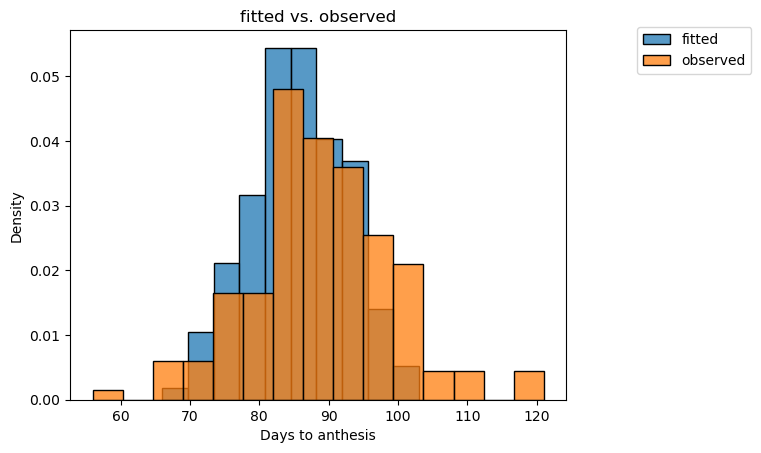

In [17]:
plot_from_saved(save_name, model, val_dl, method = 'histogram', bce=True, CNN=False)#

In [46]:
for x, y in train_dl:
    print(len(x))

500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
299


In [27]:
def K_fold_transfer(k_folds, train_ds, model_class, 
                    savename, epochs, bs, model_args, 
                    lr = 0.01, savename_prefix = 'KFold', 
                    freeze_params = False, loss = 'NLL', custom_loss = None,
                    CNN=False, bce=False):
    ## LSTM_args: input_dim, hidden_dim, num_layers, output_dim
    # Initialize the k-fold cross validation
    kf = KFold(n_splits=k_folds, shuffle=True, random_state = 1)
    # Loop through each fold
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss_values = []
    R2s = []
    Biases = []
    Variances = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(train_ds)):
        print(f"Fold {fold + 1}")

        # Define the data loaders for the current fold
        train_dl = DataLoader(
            dataset=train_ds,
            batch_size=bs,
            sampler=torch.utils.data.SubsetRandomSampler(train_idx),
        )
        val_dl = DataLoader(
            dataset=train_ds,
            batch_size=bs,
            sampler=torch.utils.data.SubsetRandomSampler(test_idx),
        )

        # Initialize the model and optimizer
        model = model_class(*model_args).to(device)
        
        model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
        model_path = os.path.join(model_dir, savename + ".pt")
        checkpoint = torch.load(model_path, weights_only=True)
        model.load_state_dict(checkpoint['model_state_dict'])
        #for param in model.fc.parameters():
        #    param.requires_grad = False
        #for param in model.lstm.parameters():
        #    param.requires_grad = False
        for param in model.parameters():
            param.requires_grad = False
        for param in [model.u0, model.u1, model.u2, model.u3, model.u4, model.p0]:
            param.requires_grad = True
        
        optimizer = optim.Adam(model.parameters(), lr=lr)
        if loss == 'NLL':
            criterion = nn.NLLLoss()
        elif loss == 'BCE':
            criterion = nn.BCELoss()
        elif loss == 'MSE':
            criterion = custom_loss
        # Train the model on the current fold
        if freeze_params:
            for param in [model.u0, model.u1, model.u2, model.u3, model.u4, model.p0]:
                param.requires_grad = False

        model_loss = fit_for_kf(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = savename_prefix + str(fold + 1), CNN=CNN, bce=bce)
        loss_values.append(model_loss)

        #Now look at stats for model:
        model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
        model_path = os.path.join(model_dir, savename_prefix + str(fold + 1) + ".pt")
        checkpoint = torch.load(model_path, weights_only=True)
        TS_model = model_class(*model_args).to(device)
        TS_model.load_state_dict(checkpoint['model_state_dict'])

        # Now convert to days and get R^2 to compare to other models
        list_logs = []
        list_observed = []
        for xb, yb in val_dl:
            with torch.no_grad():
                if CNN:
                    list_logs.append(TS_model(xb))
                else:
                    list_logs.append(TS_model(xb.transpose(1, 2)))
                #print(TS_model(xb.transpose(1, 2)))
            list_observed.append(yb)
        logs = torch.squeeze(torch.cat(list_logs))
        if bce:
            fitted = torch.round(logs)
        else:
            fitted = torch.argmax(logs, dim=2)
        L = fitted.shape[1]
        fitted_days = L - fitted.sum(dim=1)
        observed = torch.cat(list_observed)
        observed_days = L - observed.sum(dim=1)
        comparison_frame = pd.DataFrame({'fitted': fitted_days.numpy().squeeze(), 'observed': observed_days.numpy().squeeze()})
        
        rsquared = r2_score(comparison_frame['observed'], comparison_frame['fitted'])
        bias = comparison_frame['observed'].mean() - comparison_frame['fitted'].mean()
        variance_modelled = comparison_frame[f'fitted'].var()
        
        R2s.append(rsquared)
        Biases.append(bias)
        Variances.append(variance_modelled)

    return loss_values, R2s, Biases, Variances

In [51]:
input_dim = 4
savename = 'NN_response_SSA' #'LSTM_KG_SAT_pp'save_name = 'CCNN_SAT_pp_KG'
model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
model_path = os.path.join(model_dir, savename + ".pt")
checkpoint = torch.load(model_path, weights_only=True)
model = nn_temp_response(input_dim, hidden_dim, num_layers, output_dim, KG =True) #LSTMClassifier_KG(input_dim, hidden_dim, num_layers, output_dim)
model.load_state_dict(checkpoint['model_state_dict'])
for param in model.parameters():
    param.requires_grad = False
for param in [model.u0, model.u1, model.u2, model.u3, model.u4, model.p0]:
    param.requires_grad = True

RuntimeError: Error(s) in loading state_dict for nn_temp_response:
	Missing key(s) in state_dict: "u4". 

0 0.3747577965259552 53.4495735168457
5 53.58411407470703 53.4495735168457
10 53.58411407470703 53.4495735168457
15 53.58411407470703 53.4495735168457
20 53.58411407470703 53.4495735168457
25 53.58411407470703 53.4495735168457
30 53.58411407470703 53.4495735168457
35 53.58411407470703 53.4495735168457
40 53.58411407470703 53.4495735168457
45 53.58411407470703 53.4495735168457
50 53.58411407470703 53.4495735168457
55 53.58411407470703 53.4495735168457
60 53.58411407470703 53.4495735168457
65 53.58411407470703 53.4495735168457
70 53.58411407470703 53.4495735168457
75 53.58411407470703 53.4495735168457
80 53.58411407470703 53.4495735168457
85 53.58411407470703 53.4495735168457
90 53.58411407470703 53.4495735168457
95 53.58411407470703 53.4495735168457
100 53.58411407470703 53.4495735168457
105 53.58411407470703 53.4495735168457
110 53.58411407470703 53.4495735168457
115 53.58411407470703 53.4495735168457
120 53.58411407470703 53.4495735168457
125 53.58411407470703 53.4495735168457
130 53.

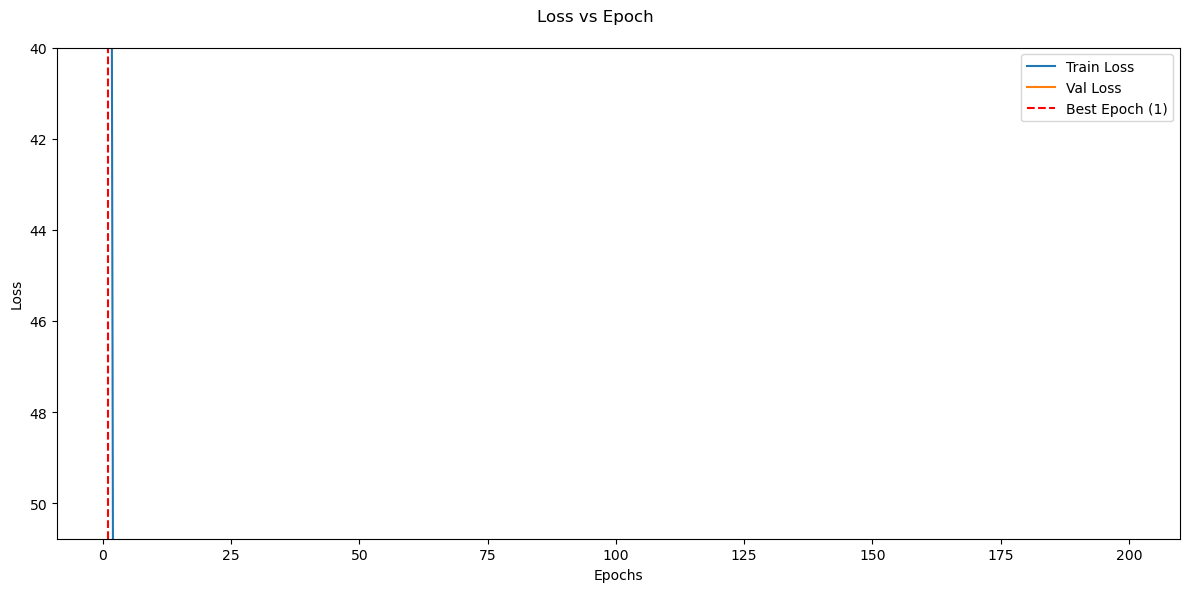

In [52]:
bs = 500
n_channels = 4
train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.5)
save_name = 'nn_KG_SSA_TL'
# Loss function and optimizer
criterion = criterion = nn.BCELoss()#nn.NLLLoss()  # For multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

epochs = 200
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN=False, bce = True)

In [49]:
k_folds=5
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
model_class = nn_temp_response
savename =  'NN_response_DE'
epochs = 200
bs = 500
input_dim = 4
hidden_dim = 16
num_layers = 4
output_dim = 1
KG = True
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG)
loss_values, R2s, Biases, Variances = K_fold_transfer(k_folds, train_ds, model_class, savename, epochs, bs, model_args, lr = 0.01, savename_prefix = 'KFold', freeze_params = False, loss = 'BCE', CNN=False, bce=True)

Fold 1
Loss: 0.11896631866693497
Fold 2
Loss: 0.11890595406293869
Fold 3
Loss: 0.11161382496356964
Fold 4
Loss: 0.11943992227315903
Fold 5
Loss: 0.10649867355823517


In [92]:
k_folds=5
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
model_class = nn_temp_response
save_name= 'NN_response_DE_no_day'
epochs = 200
bs = 500
input_dim = 5
hidden_dim = 16
num_layers = 4
output_dim = 1
KG = False
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG)
loss_values, R2s, Biases, Variances = K_fold_transfer(k_folds, train_ds, model_class, save_name, epochs, bs, model_args, lr = 0.01, savename_prefix = 'KFold', freeze_params = False, loss = 'BCE', CNN=False, bce=True)

Fold 1
Loss: 0.12871979176998138
Fold 2
Loss: 0.10623729974031448
Fold 3
Loss: 0.13243165612220764
Fold 4
Loss: 0.13086050748825073
Fold 5
Loss: 0.12835103273391724


In [93]:
R2s

[0.3179613947868347,
 0.22253692150115967,
 0.3240765929222107,
 0.16850709915161133,
 0.3345268964767456]

In [ ]:
k_folds=5
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
model_class = nn_temp_response
savename =  'NN_response_DE'
epochs = 200
bs = 500
input_dim = 4
hidden_dim = 16
num_layers = 4
output_dim = 1
KG = True
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG)
loss_values, R2s, Biases, Variances = K_fold_transfer(k_folds, train_ds, model_class, savename, epochs, bs, model_args, lr = 0.01, savename_prefix = 'KFold', freeze_params = False, loss = 'BCE', CNN=False, bce=True)

In [50]:
np.mean(R2s)

0.3838975191116333

OrderedDict([('u0', tensor([3.0300])), ('u1', tensor([0.4097])), ('u2', tensor([0.0449])), ('u3', tensor([-0.5913])), ('p0', tensor([13.])), ('lstm.weight_ih_l0', tensor([[ 0.1043, -0.1732, -0.0477,  0.1512],
        [-0.0545,  0.0497, -0.2428,  0.0014],
        [ 0.1945,  0.0507, -0.1964,  0.0299],
        [-0.2144, -0.1459, -0.0323, -0.0244],
        [-0.2213, -0.2290, -0.0947,  0.2399],
        [ 0.0758,  0.1267,  0.0760,  0.0709],
        [ 0.0857,  0.0354,  0.0365, -0.1485],
        [-0.1117, -0.0730,  0.0718, -0.1403],
        [-0.0883,  0.1695,  0.1737,  0.0485],
        [ 0.1216,  0.1737, -0.1048,  0.0343],
        [ 0.0709, -0.0815, -0.0661, -0.0558],
        [ 0.1102, -0.0238,  0.1316,  0.1946],
        [-0.0562,  0.0013, -0.1097,  0.2364],
        [-0.1537,  0.1375,  0.1374, -0.1491],
        [-0.0216,  0.2121,  0.0229, -0.1307],
        [ 0.2094,  0.1508,  0.1870,  0.1204],
        [-0.0817, -0.0098,  0.1564,  0.1775],
        [-0.2445,  0.2046, -0.1549, -0.0738],
        [

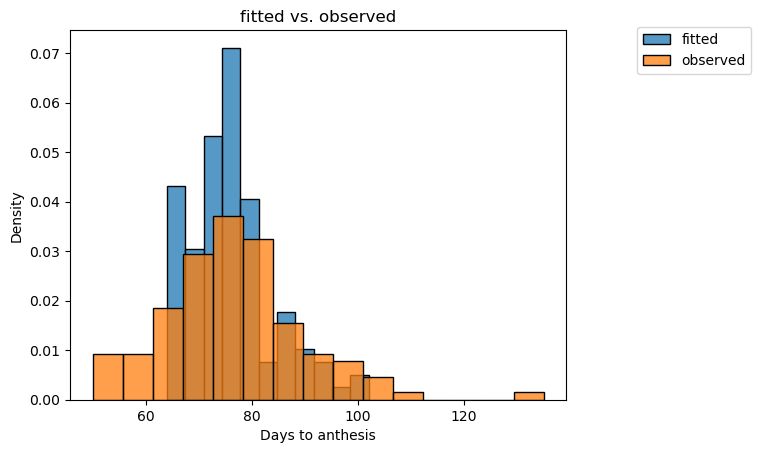

In [31]:
train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.1)
train_dl_DE, val_dl_DE = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels, train_proportion=0.1)
plot_from_saved(save_name, model, val_dl, method = 'histogram', bce=True, CNN=False)#

OrderedDict([('u0', tensor([1.1530])), ('u1', tensor([-0.1794])), ('u2', tensor([0.3816])), ('u3', tensor([-0.4020])), ('p0', tensor([13.])), ('lstm.weight_ih_l0', tensor([[-0.1974, -0.2006, -0.0475,  0.2221],
        [ 0.0257, -0.0198, -0.0496,  0.0122],
        [ 0.1149, -0.2155,  0.1518,  0.1868],
        [-0.1645, -0.1128,  0.0752,  0.1435],
        [-0.2248,  0.2379, -0.0086, -0.0520],
        [-0.1826, -0.0774,  0.1675,  0.1776],
        [ 0.2482,  0.2398,  0.1657, -0.0479],
        [ 0.1480, -0.2085,  0.2146,  0.1298],
        [-0.0570, -0.1773, -0.0914,  0.0834],
        [-0.1016, -0.1098,  0.2369,  0.0051],
        [ 0.0644,  0.1220,  0.2233,  0.2405],
        [ 0.2089, -0.1299,  0.0426,  0.0930],
        [-0.0095,  0.0818, -0.1380,  0.2496],
        [-0.0396, -0.1339,  0.2145, -0.1666],
        [ 0.1908,  0.1698,  0.0816, -0.1312],
        [ 0.2103, -0.0689,  0.0935, -0.1742],
        [-0.0281,  0.1960, -0.1748,  0.0414],
        [-0.1968, -0.1785, -0.1091,  0.2427],
        

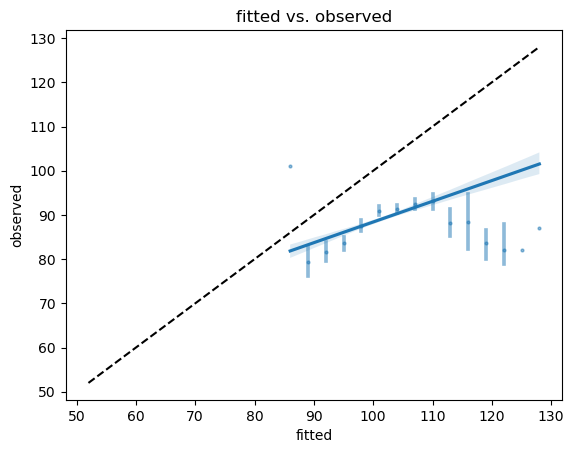

In [41]:
#save_name= 'Simple_NN_KG_SAT_pp'
train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.1)
train_dl_DE, val_dl_DE = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels, train_proportion=0.1)
plot_from_saved(save_name, model, val_dl_DE, method = 'regression', bce=bce, CNN=CNN)#

In [15]:
bs = 500
n_channels = 4

input_dim = n_channels # Example: 100-dimensional word embeddings
output_dim = 1  # Example: 5 classes

epochs = 100
model_class = nn_temp_response
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, train_proportion=1)

CNN = False
bce = True

k_folds = 5

for num_layers in [4, 8, 16]:
    for hidden_dim in [4, 8, 16]:
        print(num_layers, 'layers', ' hidden dim', hidden_dim)
        if num_layers == 4 and hidden_dim == 4:
            continue
        CNN_args = (input_dim, hidden_dim, num_layers, output_dim)
        loss_values, R2s, Biases, Variances = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, CNN_args, savename_prefix = 'KFold', loss = 'BCE', CNN=CNN, bce=bce)
        score = np.mean(loss_values)
        score_std = np.std(loss_values)
        R2_score = np.mean(R2s)
        R2_std = np.std(R2s)
        print(f'{num_layers} layers\nhidden dim {hidden_dim}\nloss {score} +/- {score_std}\nR2 {R2_score} +/- {R2_std}')

4 layers  hidden dim 4
4 layers  hidden dim 8
Fold 1
Loss: 0.09616621111788647
Fold 2
Loss: 0.09566244860446822
Fold 3
Loss: 0.09476258567863469
Fold 4
Loss: 0.09438741723520498
Fold 5
Loss: 0.09320732081260687
4 layers
hidden dim 8
loss 0.09493828170281887 +/- 0.002420975512318771
R2 0.37770284414291383 +/- 0.019117042911555693
4 layers  hidden dim 16
Fold 1
Loss: 0.09261867260383762
Fold 2
Loss: 0.09239977217391353
Fold 3
Loss: 0.09415661846640051
Fold 4
Loss: 0.09497429841538102
Fold 5
Loss: 0.09179341441275127
4 layers
hidden dim 16
loss 0.09486407761935563 +/- 0.004295512494431185
R2 0.3825199007987976 +/- 0.03583584992555995
8 layers  hidden dim 4
Fold 1
Loss: 0.0961160135534185
Fold 2
Loss: 0.10060566749309494
Fold 3
Loss: 0.09688205700984269
Fold 4
Loss: 0.09487669004143157
Fold 5
Loss: 0.09302868716818326
8 layers
hidden dim 4
loss 0.09687764126985862 +/- 0.003657330615980168
R2 0.3614853620529175 +/- 0.026865292197698572
8 layers  hidden dim 8
Fold 1
Loss: 0.09523385585723479

KeyboardInterrupt: 

4 layers
hidden dim 8
loss 0.09493828170281887 +/- 0.002420975512318771
R2 0.37770284414291383 +/- 0.019117042911555693

4 layers
hidden dim 16
loss 0.09486407761935563 +/- 0.004295512494431185
R2 0.3825199007987976 +/- 0.03583584992555995

8 layers
hidden dim 4
loss 0.09687764126985862 +/- 0.003657330615980168
R2 0.3614853620529175 +/- 0.026865292197698572

8 layers
hidden dim 8
loss 0.09825641053378115 +/- 0.0018010093072599591
R2 0.34743714332580566 +/- 0.039617697187614036

8 layers
hidden dim 16
loss 0.09622502034269967 +/- 0.0037492410465446847
R2 0.3490405440330505 +/- 0.0566075686691473

4 layers
hidden dim 4
loss 0.09671930811207077 +/- 0.0018048219953200194
R2 0.3694689631462097 +/- 0.017327979076895317

In [42]:
comparison_frame = get_comparison_frame(save_name, model, val_dl_DE, bce=bce, CNN=CNN)

In [43]:
comparison_frame['fitted'] = comparison_frame['fitted'] - comparison_frame['fitted'].mean()
comparison_frame['observed'] = comparison_frame['observed'] - comparison_frame['observed'].mean()

In [44]:
r2_score(comparison_frame['observed'] - comparison_frame['observed'].mean(), comparison_frame['fitted'] - comparison_frame['fitted'].mean()) #

-0.016082406044006348

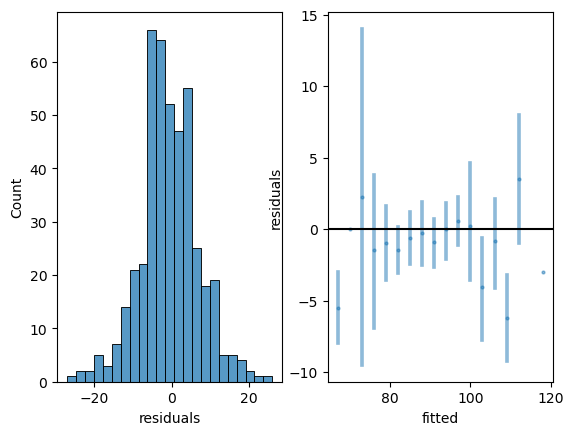

In [44]:
plot_residuals(comparison_frame)

In [43]:
def plot_residuals(comparison_frame):
    fig, axs = plt.subplots(1, 2)
    comparison_frame['residuals'] = comparison_frame['observed'] - comparison_frame['fitted']
    sns.histplot(comparison_frame['residuals'], ax = axs[0])
    maxval = max(comparison_frame['fitted'].max(), comparison_frame['residuals'].max())
    minval = min(comparison_frame['fitted'].min(), comparison_frame['residuals'].min())
    
    sns.regplot(x='fitted', y='residuals', data = comparison_frame, ax=axs[1],
                scatter_kws={'alpha':0.5, 's':4},  x_bins=np.arange(minval - 5, maxval + 5, 3),
                fit_reg = False)
    axs[1].axhline(0, color = 'black')

In [18]:
class simple_nn_Classifier_KG(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(simple_nn_Classifier_KG, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=False) # batch_first handles input shape (batch, seq, features)
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.layer1 = nn.Linear(hidden_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.layer4= nn.Linear(hidden_dim, hidden_dim)
        self.layer5 = nn.Linear(hidden_dim, hidden_dim)
        self.layer6= nn.Linear(hidden_dim, hidden_dim)
        self.layer7 = nn.Linear(hidden_dim, hidden_dim)
        self.layer8 = nn.Linear(hidden_dim, hidden_dim)
        self.layer9 = nn.Linear(hidden_dim, hidden_dim)
        self.layer10= nn.Linear(hidden_dim, hidden_dim)
        self.layer11 = nn.Linear(hidden_dim, hidden_dim)
        self.layer12 = nn.Linear(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)  # Fully connected layer for classification
        self.input_dim = input_dim
        self.sig = nn.Sigmoid()

        self.activation = nn.LeakyReLU(negative_slope=0.01)

        self.u0 = torch.nn.Parameter(torch.Tensor([1]))
        self.u1 = torch.nn.Parameter(torch.Tensor([0]))
        self.u2 = torch.nn.Parameter(torch.Tensor([0]))
        self.u3 = torch.nn.Parameter(torch.Tensor([0]))

        self.p0 = torch.nn.Parameter(torch.Tensor([13]))
        

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device) # Initialize hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device) # Initialize cell state
        # Apply Wang Engel
        T_min = 9 + 2*(torch.tanh(self.u1))
        T_opt = 28 + 3*(torch.tanh(self.u2))
        T_max = 39 + torch.tanh(self.u3)
        alpha = np.log(2)/torch.log( (T_max - T_min)/(T_opt - T_min) )
        beta = 1
        #print(T_min, T_opt, T_max)
        #print(alpha)
        #print(((2*(x - T_min)*(x >= T_min))**alpha))
        #x[:, :, 0] = ( ( ((2*(x[:, :, 0] - T_min)*(x[:, :, 0] >= T_min))**alpha)*((T_opt - T_min)**alpha) - (((x[:, :, 0] - T_min)*(x[:, :, 0] >= T_min))**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta
        #x = torch.nan_to_num(x)
        #x = x*(x >= T_min)*(x<= T_max)
        #print(x)
        #print(x, x.shape)
        # Make cumulative
        x[:, :, 0] = self.u0*torch.cumsum(x[:, :, 0], dim = 1)
        if self.input_dim == 3:
            x[:, :, 1] = 0.5*(1 + torch.tanh(2*(x[:, :, 1] - self.p0)))
        # Forward pass through LSTM
        #x = torch.swapaxes(x, 1, 2)
        for i, linlayer in enumerate([self.input_layer, self.layer1, self.layer2, self.layer3, 
                                      self.layer4, self.layer5, self.layer6,
                                      self.layer7, self.layer8, self.layer9,
                                      self.layer10, self.layer11, self.layer12]):
            #print(i)
            #print(x.shape)
            #print(conv)
            x = linlayer(x)
            x = self.activation(x)
            #x = x[:, :, :-conv.padding[0]]
        #torch.nn.init.xavier_uniform(self.fc.weight)
        # Get the hidden state of the last time step
        # output[:, -1, :] is more efficient for batch_first=True
        #last_hidden = output[:, -1, :] # (batch, hidden_dim)
        #print(self.fc(output))
        
        # Classify all layers using fully connected layer
        out_space = self.fc(x) # (batch, output_dim)
        if self.output_dim == 1:
            out_scores = self.sig(out_space)
        else:
            out_scores = F.log_softmax(out_space, dim=2)


        return out_scores

In [ ]:
bs = 250
n_channels = 3

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8
num_layers = 2
output_dim = 2  # Example: 5 classes

epochs = 50
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, train_proportion=1)
k_folds = 5
model_args = (input_dim, hidden_dim, num_layers, output_dim)

model_class = simple_nn_Classifier_KG

loss_values_raw, R2s_raw, Biases_raw, Variances_raw = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, model_args, savename_prefix = 'KFold', freeze_params=True, loss='NLL', bce=False, CNN=False)

Fold 1
Loss: 0.08391246811878504
Fold 2
Loss: 0.08361983797087426
Fold 3
Loss: 0.08282656307082939
Fold 4
Loss: 0.0840181593704131
Fold 5
Loss: 0.08372888977491157


In [ ]:
score = np.mean(loss_values_raw)
score_stde = np.std(loss_values_raw)/np.sqrt(5)
R2_score = np.mean(R2s_raw)
R2_stde = np.std(R2s_raw)/np.sqrt(5)
print(f'#### simple nn model SSA ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}')

#### simple nn model SSA ####
loss 0.09319833964109421 +/- 0.008512759681746064
R2 0.3604199528694153 +/- 0.07515899247537987


In [ ]:
score = np.mean(loss_values_raw)
score_stde = np.std(loss_values_raw)/np.sqrt(5)
R2_score = np.mean(R2s_raw)
R2_stde = np.std(R2s_raw)/np.sqrt(5)
Bias = np.mean(Biases_raw)
Variance = np.mean(Variances_raw)
print(f'#### simple nn model ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}')

#### simple nn model ####
loss 0.0839767403257725 +/- 0.0007066481698857139
R2 0.32629200220108034 +/- 0.00820013488725414


In [ ]:
print(Bias, Variance)

1.3918283516135772 34.686642827690136


OrderedDict([('u0', tensor([0.9372])), ('u1', tensor([0.])), ('u2', tensor([0.])), ('u3', tensor([0.])), ('p0', tensor([13.4497])), ('lstm.weight_ih_l0', tensor([[ 1.2259e-01, -1.0271e-02, -1.4785e-01],
        [ 8.1613e-02,  1.2288e-01, -1.1837e-01],
        [-1.1447e-01, -5.7956e-02,  7.2874e-02],
        [-2.6153e-02, -3.6232e-02,  6.4837e-02],
        [-1.5935e-02, -5.5384e-02, -8.1134e-02],
        [ 1.6410e-01,  4.0563e-02,  1.0685e-01],
        [-1.6115e-01,  9.1416e-02,  5.6207e-02],
        [-9.0601e-03, -1.1208e-01, -1.7060e-01],
        [ 1.3888e-01, -1.1498e-01, -1.1597e-01],
        [ 1.1428e-01, -1.1882e-01,  6.1536e-02],
        [-1.0707e-01, -7.9775e-02,  6.9671e-02],
        [ 2.4617e-02, -9.0246e-02, -3.8770e-03],
        [-9.0492e-02,  9.5185e-02,  2.5435e-02],
        [ 1.5126e-01, -8.1294e-02,  1.1947e-01],
        [-1.4448e-01,  1.1778e-01, -1.1594e-01],
        [ 1.2721e-01,  1.2488e-01,  4.7802e-02],
        [ 1.5589e-01, -5.9244e-02, -3.5436e-02],
        [-8.7

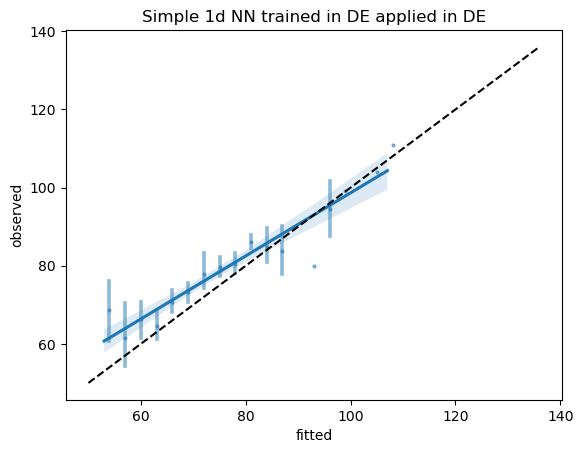

In [ ]:
temp_NDVI_series_SSA = torch.swapaxes(torch.stack((temp_series_SSA, photoperiod_series_SSA, NDVI_series_SSA)), 0, 1) #photoperiod_series_SSA, 
train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.1)
plot_from_saved('Simple_NN_KG_SAT_pp', model, val_dl_SSA, method = 'regression', bce=True, CNN=False, title = 'Simple 1d NN trained in DE applied in DE')#